In [1]:
pip install us


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import pearsonr
from scipy.stats import ks_2samp
import us

## Data Cleaning

### Food Access Dataset

Below is our Food Access dataset, collected from the United States Department of Agriculture's Food Access Research Atlas of 2019 that provides information of food access indicators country-wide. The data is recorded per Census Tract for a county on food access through the dataset. The dataset is large, with 72,531 instances and 147 different features with counties having multiple entries. Because each entry is identifiable by the census tract and not by county, we performed some data cleaning to aggregate the data to make the resulting data frame have each row represent one county's data. This also helped merge our data with the Cause of Death dataset, which identifies each entry by county.

In [3]:
# Import food desert dataset
df_food = pd.read_excel('FoodAccessResearchAtlasData2019.xlsx', sheet_name = 'Food Access Research Atlas')
df_food

,CensusTract,State,County,Urban,Pop2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,...,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP
0,1001020100,Alabama,Autauga County,1,1912,693,0,0.0,0.000000,0,...,221.0,1622.0,217.0,14.0,0.0,14.0,45.0,44.0,6.0,102.0
1,1001020200,Alabama,Autauga County,1,2170,743,0,181.0,8.341014,1,...,214.0,888.0,1217.0,5.0,0.0,5.0,55.0,75.0,89.0,156.0
2,1001020300,Alabama,Autauga County,1,3373,1256,0,0.0,0.000000,0,...,439.0,2576.0,647.0,17.0,5.0,11.0,117.0,87.0,99.0,172.0
3,1001020400,Alabama,Autauga County,1,4386,1722,0,0.0,0.000000,0,...,904.0,4086.0,193.0,18.0,4.0,11.0,74.0,85.0,21.0,98.0
4,1001020500,Alabama,Autauga County,1,10766,4082,0,181.0,1.681219,0,...,1126.0,8666.0,1437.0,296.0,9.0,48.0,310.0,355.0,230.0,339.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72526,56043000200,Wyoming,Washakie County,0,3326,1317,0,57.0,1.713770,0,...,593.0,3106.0,6.0,15.0,0.0,27.0,172.0,309.0,61.0,64.0
72527,56043000301,Wyoming,Washakie County,1,2665,1154,0,10.0,0.375235,0,...,399.0,2377.0,5.0,23.0,0.0,40.0,220.0,446.0,88.0,41.0
72528,56043000302,Wyoming,Washakie County,1,2542,1021,0,73.0,2.871755,0,...,516.0,2312.0,11.0,10.0,1.0,26.0,182.0,407.0,23.0,64.0
72529,56045951100,Wyoming,Weston County,0,3314,1322,0,252.0,7.604104,0,...,499.0,3179.0,15.0,10.0,1.0,47.0,62.0,91.0,47.0,34.0


In [4]:
##df_nulls = df_food[df_food.isna().any(axis=1)]

##columns_with_nulls = df_nulls.columns[df_nulls.isna().any()].tolist()

In [5]:
##columns_with_nulls

In [6]:
##columns_to_impute = [col for col in df_food.columns if 'la' in col[:2] or "LA" in col[:2]]

##for col in columns_to_impute[8:]:
##    print(df_food[col].isna().sum())

In [7]:
# df_food['NUMGQTRS'] = df_food['NUMGQTRS'].fillna(-1)
# df_food['PCTGQTRS'] = df_food['PCTGQTRS'].fillna(-1)
# df_food['PovertyRate'] = df_food['PovertyRate'].fillna(-1)
# df_food['MedianFamilyIncome'] = df_food.groupby('County')['MedianFamilyIncome'].transform(lambda x: x.fillna(x.mean()))

In [8]:
df_food.columns = df_food.columns.str.strip()

To change the food access dataset to be 1 entry per county, we combined all the tracts of a county by summing up the features. As well, some variables within the dataset represented a percentage of the tract that was calculated by dividing the county's total population feature for that census tract. Because of this, we removed all the columns that were shares in our dataset to have meaningful aggregates.

In [9]:
# The dataset is split up by tract, so we aim to combine all tracts of a county. Some variables are already defined as "shares" or percentages
# so we can remove all columns with share in name since they were a tract percentage divided by the county total population.
df_food_new = df_food.loc[:, ~df_food.columns.str.contains("share", case=False)]
df_food_new

,CensusTract,State,County,Urban,Pop2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,...,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP
0,1001020100,Alabama,Autauga County,1,1912,693,0,0.0,0.000000,0,...,221.0,1622.0,217.0,14.0,0.0,14.0,45.0,44.0,6.0,102.0
1,1001020200,Alabama,Autauga County,1,2170,743,0,181.0,8.341014,1,...,214.0,888.0,1217.0,5.0,0.0,5.0,55.0,75.0,89.0,156.0
2,1001020300,Alabama,Autauga County,1,3373,1256,0,0.0,0.000000,0,...,439.0,2576.0,647.0,17.0,5.0,11.0,117.0,87.0,99.0,172.0
3,1001020400,Alabama,Autauga County,1,4386,1722,0,0.0,0.000000,0,...,904.0,4086.0,193.0,18.0,4.0,11.0,74.0,85.0,21.0,98.0
4,1001020500,Alabama,Autauga County,1,10766,4082,0,181.0,1.681219,0,...,1126.0,8666.0,1437.0,296.0,9.0,48.0,310.0,355.0,230.0,339.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72526,56043000200,Wyoming,Washakie County,0,3326,1317,0,57.0,1.713770,0,...,593.0,3106.0,6.0,15.0,0.0,27.0,172.0,309.0,61.0,64.0
72527,56043000301,Wyoming,Washakie County,1,2665,1154,0,10.0,0.375235,0,...,399.0,2377.0,5.0,23.0,0.0,40.0,220.0,446.0,88.0,41.0
72528,56043000302,Wyoming,Washakie County,1,2542,1021,0,73.0,2.871755,0,...,516.0,2312.0,11.0,10.0,1.0,26.0,182.0,407.0,23.0,64.0
72529,56045951100,Wyoming,Weston County,0,3314,1322,0,252.0,7.604104,0,...,499.0,3179.0,15.0,10.0,1.0,47.0,62.0,91.0,47.0,34.0


The variables we wanted to aggregate per county was chosen below by including all numerical features and dropping identifiers such as 'CensusTract' and binary variables like 'GroupQuartersFlag' and 'HUNVFlag', which represents group quarters that had a share of >= 67 and vehicle access where >= 100 households did not have access to a vehicle and were 1/2 a mile from the supermarkets. Combined_variables shows the variables of focus to combine when doing our aggregation.

In [10]:
# We can define the variables of a tract that we do want to combine when grouping by county
combined_variables = df_food_new.select_dtypes(include=['number']).drop(columns=['CensusTract', 'GroupQuartersFlag', 'HUNVFlag'], errors='ignore').columns.to_list()
combined_variables

['Urban',
 'Pop2010',
 'OHU2010',
 'NUMGQTRS',
 'PCTGQTRS',
 'LILATracts_1And10',
 'LILATracts_halfAnd10',
 'LILATracts_1And20',
 'LILATracts_Vehicle',
 'LowIncomeTracts',
 'PovertyRate',
 'MedianFamilyIncome',
 'LA1and10',
 'LAhalfand10',
 'LA1and20',
 'LATracts_half',
 'LATracts1',
 'LATracts10',
 'LATracts20',
 'LATractsVehicle_20',
 'LAPOP1_10',
 'LAPOP05_10',
 'LAPOP1_20',
 'LALOWI1_10',
 'LALOWI05_10',
 'LALOWI1_20',
 'lapophalf',
 'lalowihalf',
 'lakidshalf',
 'laseniorshalf',
 'lawhitehalf',
 'lablackhalf',
 'laasianhalf',
 'lanhopihalf',
 'laaianhalf',
 'laomultirhalf',
 'lahisphalf',
 'lahunvhalf',
 'lasnaphalf',
 'lapop1',
 'lalowi1',
 'lakids1',
 'laseniors1',
 'lawhite1',
 'lablack1',
 'laasian1',
 'lanhopi1',
 'laaian1',
 'laomultir1',
 'lahisp1',
 'lahunv1',
 'lasnap1',
 'lapop10',
 'lalowi10',
 'lakids10',
 'laseniors10',
 'lawhite10',
 'lablack10',
 'laasian10',
 'lanhopi10',
 'laaian10',
 'laomultir10',
 'lahisp10',
 'lahunv10',
 'lasnap10',
 'lapop20',
 'lalowi20',
 

To make our new dataframe, we grouped the instances by State and County to account for the same county existing in multiple states and took the sum of all the values per each state and county, with the new name of total_{variable_name} for each variable_name in our defined combined_variables list of important columns to aggregate. 'MedianFamilyIncome' was the only column that we decided to take the average of outside of the combined_variables list

In [11]:
# Here we group by State and County and take the sum for all variables except 'MedianFamilyIncome', where we took the average of the tracts
# of a given county.
df_food_new = df_food_new.groupby(['State', 'County']).agg(
    # total_population=('Pop2010', 'sum'),
    avg_median_family_income=('MedianFamilyIncome', 'mean'),
    **{f'total_{var}': (var, 'sum') for var in combined_variables}
).reset_index()

After making the dataframe with our new summed values, we created a list of the columns of interest from combined_variables to note down all the variables from the new dataframe, df_food_new, for all the new shares we will calculate from the totaled columns.

In [12]:
# Define variable list that we want to create new shares from using 'total_population'
total_combined_variables=[x for x in combined_variables if x != "MedianFamilyIncome"]
total_combined_variables=[f'total_{i}' for i in combined_variables]
total_combined_variables

['total_Urban',
 'total_Pop2010',
 'total_OHU2010',
 'total_NUMGQTRS',
 'total_PCTGQTRS',
 'total_LILATracts_1And10',
 'total_LILATracts_halfAnd10',
 'total_LILATracts_1And20',
 'total_LILATracts_Vehicle',
 'total_LowIncomeTracts',
 'total_PovertyRate',
 'total_MedianFamilyIncome',
 'total_LA1and10',
 'total_LAhalfand10',
 'total_LA1and20',
 'total_LATracts_half',
 'total_LATracts1',
 'total_LATracts10',
 'total_LATracts20',
 'total_LATractsVehicle_20',
 'total_LAPOP1_10',
 'total_LAPOP05_10',
 'total_LAPOP1_20',
 'total_LALOWI1_10',
 'total_LALOWI05_10',
 'total_LALOWI1_20',
 'total_lapophalf',
 'total_lalowihalf',
 'total_lakidshalf',
 'total_laseniorshalf',
 'total_lawhitehalf',
 'total_lablackhalf',
 'total_laasianhalf',
 'total_lanhopihalf',
 'total_laaianhalf',
 'total_laomultirhalf',
 'total_lahisphalf',
 'total_lahunvhalf',
 'total_lasnaphalf',
 'total_lapop1',
 'total_lalowi1',
 'total_lakids1',
 'total_laseniors1',
 'total_lawhite1',
 'total_lablack1',
 'total_laasian1',
 'to

Then iteratively, we looped over all the variables that were greated from the summed aggregation and made shares of those variables by dividing the totals by the total population that was summed up for each county. Each of these new share columns were named as {variable}_share, with variable being the columns created from summing up the values per county per state. 

In [13]:
for var in total_combined_variables:
    df_food_new[f"{var}_share"] = df_food_new[var] / df_food_new["total_Pop2010"]
df_food_new

,State,County,avg_median_family_income,total_Urban,total_Pop2010,total_OHU2010,total_NUMGQTRS,total_PCTGQTRS,total_LILATracts_1And10,total_LILATracts_halfAnd10,...,total_TractSeniors_share,total_TractWhite_share,total_TractBlack_share,total_TractAsian_share,total_TractNHOPI_share,total_TractAIAN_share,total_TractOMultir_share,total_TractHispanic_share,total_TractHUNV_share,total_TractSNAP_share
0,Alabama,Autauga County,69337.500000,7,54571,20221,455.0,12.853691,5,5,...,0.119954,0.785307,0.176706,0.008686,0.000586,0.004251,0.024464,0.024005,0.021825,0.049330
1,Alabama,Baldwin County,72665.741935,14,182265,73180,2307.0,41.062742,4,4,...,0.167712,0.856736,0.093847,0.007396,0.000488,0.006672,0.034861,0.043848,0.014841,0.032513
2,Alabama,Barbour County,44792.444444,2,27457,9820,3193.0,79.735470,4,5,...,0.142368,0.480023,0.468915,0.003897,0.001056,0.004152,0.041957,0.050515,0.030921,0.091634
3,Alabama,Bibb County,60645.500000,0,22915,7953,2224.0,26.251382,0,0,...,0.126816,0.758499,0.220249,0.000960,0.000567,0.002793,0.016932,0.017718,0.017892,0.037050
4,Alabama,Blount County,60437.666667,1,57322,21578,489.0,7.248861,0,0,...,0.147221,0.925788,0.013276,0.002041,0.000663,0.005356,0.052877,0.080702,0.014933,0.034297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,Wyoming,Sweetwater County,85896.833333,6,43806,16475,679.0,20.529943,0,0,...,0.083162,0.884536,0.009999,0.007670,0.000959,0.009656,0.087180,0.152696,0.008857,0.020888
3138,Wyoming,Teton County,112766.750000,1,21294,8973,271.0,7.196154,0,0,...,0.098525,0.883864,0.002301,0.011036,0.000704,0.005213,0.096882,0.149854,0.010238,0.008923
3139,Wyoming,Uinta County,70347.666667,0,21118,7668,270.0,3.590040,0,0,...,0.088739,0.924046,0.002604,0.002889,0.001705,0.007955,0.060801,0.087840,0.014301,0.026186
3140,Wyoming,Washakie County,67003.666667,2,8533,3492,140.0,4.960759,0,0,...,0.176726,0.913512,0.002578,0.005625,0.000117,0.010899,0.067268,0.136177,0.020157,0.019805


In [14]:
#df_food_new[[f"{var}_share" for var in total_combined_variables]] = df_food_new[[f"{var}_share" for var in total_combined_variables]].apply(
#    lambda x: x / df_food_new["total_population"])

Before we merged our dataframe with the cause of death dataframe, we created 'State_Abbr' from the 'State' values in our dataframe to effectively merge by both the state and county. 

In [15]:
# Add state abbreviations in preparation for a merge with our other dataset
df_food_new = df_food_new.assign(State_Abbr=df_food_new['State'].map(lambda x: us.states.lookup(x).abbr if us.states.lookup(x) else None))
df_food_new = df_food_new.drop(columns=["State"])

Below, df_food_new is our processed, cleaned version of the food access dataset.

In [16]:
df_food_new

,County,avg_median_family_income,total_Urban,total_Pop2010,total_OHU2010,total_NUMGQTRS,total_PCTGQTRS,total_LILATracts_1And10,total_LILATracts_halfAnd10,total_LILATracts_1And20,...,total_TractWhite_share,total_TractBlack_share,total_TractAsian_share,total_TractNHOPI_share,total_TractAIAN_share,total_TractOMultir_share,total_TractHispanic_share,total_TractHUNV_share,total_TractSNAP_share,State_Abbr
0,Autauga County,69337.500000,7,54571,20221,455.0,12.853691,5,5,3,...,0.785307,0.176706,0.008686,0.000586,0.004251,0.024464,0.024005,0.021825,0.049330,AL
1,Baldwin County,72665.741935,14,182265,73180,2307.0,41.062742,4,4,3,...,0.856736,0.093847,0.007396,0.000488,0.006672,0.034861,0.043848,0.014841,0.032513,AL
2,Barbour County,44792.444444,2,27457,9820,3193.0,79.735470,4,5,1,...,0.480023,0.468915,0.003897,0.001056,0.004152,0.041957,0.050515,0.030921,0.091634,AL
3,Bibb County,60645.500000,0,22915,7953,2224.0,26.251382,0,0,0,...,0.758499,0.220249,0.000960,0.000567,0.002793,0.016932,0.017718,0.017892,0.037050,AL
4,Blount County,60437.666667,1,57322,21578,489.0,7.248861,0,0,0,...,0.925788,0.013276,0.002041,0.000663,0.005356,0.052877,0.080702,0.014933,0.034297,AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,Sweetwater County,85896.833333,6,43806,16475,679.0,20.529943,0,0,0,...,0.884536,0.009999,0.007670,0.000959,0.009656,0.087180,0.152696,0.008857,0.020888,WY
3138,Teton County,112766.750000,1,21294,8973,271.0,7.196154,0,0,0,...,0.883864,0.002301,0.011036,0.000704,0.005213,0.096882,0.149854,0.010238,0.008923,WY
3139,Uinta County,70347.666667,0,21118,7668,270.0,3.590040,0,0,0,...,0.924046,0.002604,0.002889,0.001705,0.007955,0.060801,0.087840,0.014301,0.026186,WY
3140,Washakie County,67003.666667,2,8533,3492,140.0,4.960759,0,0,0,...,0.913512,0.002578,0.005625,0.000117,0.010899,0.067268,0.136177,0.020157,0.019805,WY


### Death by County Dataset 

This dataset is the underlying cause of death dataset, collected from 2018-2023. The dataset has an instance for each county, identified by the County column by county name, state abbreviation and their County Code. The dataset has the columns County for the county, the County Code that identifies each county, the number of deaths recorded due to a nutritional and metabolic diseases in the Deaths column, the Population of the county, and the Crude Rate per 100,000 which is the percentage of deaths per 100,000 of the population. 

In [17]:
# Import mortality dataset
df_death = pd.read_excel('Underlying Cause of Death, 2018-2023, Single Race.xlsx')
df_death

,County,County Code,Deaths,Population,"Crude Rate per 100,000"
0,"Autauga County, AL",1001.0,35,55869,62.6
1,"Baldwin County, AL",1003.0,108,223234,48.4
2,"Barbour County, AL",1005.0,11,24686,Unreliable
3,"Blount County, AL",1009.0,18,57826,Unreliable
4,"Butler County, AL",1013.0,24,19448,123.4
...,...,...,...,...,...
1985,"Natrona County, WY",56025.0,39,79858,48.8
1986,"Park County, WY",56029.0,11,29194,Unreliable
1987,"Sheridan County, WY",56033.0,10,30485,Unreliable
1988,"Sweetwater County, WY",56037.0,21,42343,49.6


For data cleaning for this dataset, we created separate columns for the State and County of each county entry for easier merging with the Food Access dataset. 

In [18]:
# Create separate County and State columns in preparation for the merge
df_death["County_State"]=df_death["County"]
df_death['State'] = df_death['County_State'].str.split(", ").str[1]
df_death['County'] = df_death['County_State'].str.split(", ").str[0]
df_death

,County,County Code,Deaths,Population,"Crude Rate per 100,000",County_State,State
0,Autauga County,1001.0,35,55869,62.6,"Autauga County, AL",AL
1,Baldwin County,1003.0,108,223234,48.4,"Baldwin County, AL",AL
2,Barbour County,1005.0,11,24686,Unreliable,"Barbour County, AL",AL
3,Blount County,1009.0,18,57826,Unreliable,"Blount County, AL",AL
4,Butler County,1013.0,24,19448,123.4,"Butler County, AL",AL
...,...,...,...,...,...,...,...
1985,Natrona County,56025.0,39,79858,48.8,"Natrona County, WY",WY
1986,Park County,56029.0,11,29194,Unreliable,"Park County, WY",WY
1987,Sheridan County,56033.0,10,30485,Unreliable,"Sheridan County, WY",WY
1988,Sweetwater County,56037.0,21,42343,49.6,"Sweetwater County, WY",WY


As well, we investigated the missingness in our data, which resulted in one county entry with null values. Since it was only one county that had null values, we removed that one county before further data cleaning and merging.

In [19]:
# Remove counties that have missing data.
df_death = df_death.dropna()
df_death

,County,County Code,Deaths,Population,"Crude Rate per 100,000",County_State,State
0,Autauga County,1001.0,35,55869,62.6,"Autauga County, AL",AL
1,Baldwin County,1003.0,108,223234,48.4,"Baldwin County, AL",AL
2,Barbour County,1005.0,11,24686,Unreliable,"Barbour County, AL",AL
3,Blount County,1009.0,18,57826,Unreliable,"Blount County, AL",AL
4,Butler County,1013.0,24,19448,123.4,"Butler County, AL",AL
...,...,...,...,...,...,...,...
1984,Laramie County,56021.0,51,99500,51.3,"Laramie County, WY",WY
1985,Natrona County,56025.0,39,79858,48.8,"Natrona County, WY",WY
1986,Park County,56029.0,11,29194,Unreliable,"Park County, WY",WY
1987,Sheridan County,56033.0,10,30485,Unreliable,"Sheridan County, WY",WY


We filtered the dataset to only include County_State, State, County, and Deaths to merge with our Food Access dataset because the mortality rate per 100,000 will be recaculated using the total population aggregated by county from the food access dataset to have one column representing the mortality rate per county.

In [20]:
# Query only relevant columns. We will recalculate the crude mortality rate per 100,000 using 'Deaths' from this dataset and the total 
# population from the other dataset once we perform the merge.
df_death=df_death.filter(items=["County_State", "State", "County", "Deaths"])
df_death

,County_State,State,County,Deaths
0,"Autauga County, AL",AL,Autauga County,35
1,"Baldwin County, AL",AL,Baldwin County,108
2,"Barbour County, AL",AL,Barbour County,11
3,"Blount County, AL",AL,Blount County,18
4,"Butler County, AL",AL,Butler County,24
...,...,...,...,...
1984,"Laramie County, WY",WY,Laramie County,51
1985,"Natrona County, WY",WY,Natrona County,39
1986,"Park County, WY",WY,Park County,11
1987,"Sheridan County, WY",WY,Sheridan County,10


In [21]:
##df_death['Crude Rate per 100,000'] = df_death['Crude Rate per 100,000'].apply(lambda x: 0.00 if x == 'Unreliable' else x)
##df_death['Crude Rate per 100,000'] = df_death['Crude Rate per 100,000'].astype('float')

We looked at the data types for each column we selected, which is shown below. County_State, State, and County were all objects and Deaths was an integer value. We remade the data types for County, State, and County_State as categories for further analysis.

In [22]:
df_death.dtypes

County_State    object
State           object
County          object
Deaths           int64
dtype: object

In [23]:
# Convert relevant columns to correct data type
df_death['County_State'] = df_death['County_State'].astype('category')
df_death['State'] = df_death['State'].astype('category')
df_death['County'] = df_death['County'].astype('category')
df_death

,County_State,State,County,Deaths
0,"Autauga County, AL",AL,Autauga County,35
1,"Baldwin County, AL",AL,Baldwin County,108
2,"Barbour County, AL",AL,Barbour County,11
3,"Blount County, AL",AL,Blount County,18
4,"Butler County, AL",AL,Butler County,24
...,...,...,...,...
1984,"Laramie County, WY",WY,Laramie County,51
1985,"Natrona County, WY",WY,Natrona County,39
1986,"Park County, WY",WY,Park County,11
1987,"Sheridan County, WY",WY,Sheridan County,10


### Merging Datasets

In [24]:
df_death

,County_State,State,County,Deaths
0,"Autauga County, AL",AL,Autauga County,35
1,"Baldwin County, AL",AL,Baldwin County,108
2,"Barbour County, AL",AL,Barbour County,11
3,"Blount County, AL",AL,Blount County,18
4,"Butler County, AL",AL,Butler County,24
...,...,...,...,...
1984,"Laramie County, WY",WY,Laramie County,51
1985,"Natrona County, WY",WY,Natrona County,39
1986,"Park County, WY",WY,Park County,11
1987,"Sheridan County, WY",WY,Sheridan County,10


In [25]:
df_food_new

,County,avg_median_family_income,total_Urban,total_Pop2010,total_OHU2010,total_NUMGQTRS,total_PCTGQTRS,total_LILATracts_1And10,total_LILATracts_halfAnd10,total_LILATracts_1And20,...,total_TractWhite_share,total_TractBlack_share,total_TractAsian_share,total_TractNHOPI_share,total_TractAIAN_share,total_TractOMultir_share,total_TractHispanic_share,total_TractHUNV_share,total_TractSNAP_share,State_Abbr
0,Autauga County,69337.500000,7,54571,20221,455.0,12.853691,5,5,3,...,0.785307,0.176706,0.008686,0.000586,0.004251,0.024464,0.024005,0.021825,0.049330,AL
1,Baldwin County,72665.741935,14,182265,73180,2307.0,41.062742,4,4,3,...,0.856736,0.093847,0.007396,0.000488,0.006672,0.034861,0.043848,0.014841,0.032513,AL
2,Barbour County,44792.444444,2,27457,9820,3193.0,79.735470,4,5,1,...,0.480023,0.468915,0.003897,0.001056,0.004152,0.041957,0.050515,0.030921,0.091634,AL
3,Bibb County,60645.500000,0,22915,7953,2224.0,26.251382,0,0,0,...,0.758499,0.220249,0.000960,0.000567,0.002793,0.016932,0.017718,0.017892,0.037050,AL
4,Blount County,60437.666667,1,57322,21578,489.0,7.248861,0,0,0,...,0.925788,0.013276,0.002041,0.000663,0.005356,0.052877,0.080702,0.014933,0.034297,AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,Sweetwater County,85896.833333,6,43806,16475,679.0,20.529943,0,0,0,...,0.884536,0.009999,0.007670,0.000959,0.009656,0.087180,0.152696,0.008857,0.020888,WY
3138,Teton County,112766.750000,1,21294,8973,271.0,7.196154,0,0,0,...,0.883864,0.002301,0.011036,0.000704,0.005213,0.096882,0.149854,0.010238,0.008923,WY
3139,Uinta County,70347.666667,0,21118,7668,270.0,3.590040,0,0,0,...,0.924046,0.002604,0.002889,0.001705,0.007955,0.060801,0.087840,0.014301,0.026186,WY
3140,Washakie County,67003.666667,2,8533,3492,140.0,4.960759,0,0,0,...,0.913512,0.002578,0.005625,0.000117,0.010899,0.067268,0.136177,0.020157,0.019805,WY


After cleaning both the datasets, we merged the two datasets on their State and County values through an inner merge to keep counties that show up in both datasets. 

In [26]:
# Perform inner merge on the state abbreviation and county name from each dataset
df_merged = df_death.merge(df_food_new, how = 'inner', left_on = ['State', 'County'], right_on = ['State_Abbr', 'County'])
df_merged = df_merged.drop(columns=["State_Abbr"])
df_merged

,County_State,State,County,Deaths,avg_median_family_income,total_Urban,total_Pop2010,total_OHU2010,total_NUMGQTRS,total_PCTGQTRS,...,total_TractSeniors_share,total_TractWhite_share,total_TractBlack_share,total_TractAsian_share,total_TractNHOPI_share,total_TractAIAN_share,total_TractOMultir_share,total_TractHispanic_share,total_TractHUNV_share,total_TractSNAP_share
0,"Autauga County, AL",AL,Autauga County,35,69337.500000,7,54571,20221,455.0,12.853691,...,0.119954,0.785307,0.176706,0.008686,0.000586,0.004251,0.024464,0.024005,0.021825,0.049330
1,"Baldwin County, AL",AL,Baldwin County,108,72665.741935,14,182265,73180,2307.0,41.062742,...,0.167712,0.856736,0.093847,0.007396,0.000488,0.006672,0.034861,0.043848,0.014841,0.032513
2,"Barbour County, AL",AL,Barbour County,11,44792.444444,2,27457,9820,3193.0,79.735470,...,0.142368,0.480023,0.468915,0.003897,0.001056,0.004152,0.041957,0.050515,0.030921,0.091634
3,"Blount County, AL",AL,Blount County,18,60437.666667,1,57322,21578,489.0,7.248861,...,0.147221,0.925788,0.013276,0.002041,0.000663,0.005356,0.052877,0.080702,0.014933,0.034297
4,"Butler County, AL",AL,Butler County,24,50170.666667,2,20947,8491,333.0,11.934450,...,0.166563,0.544183,0.434191,0.008450,0.000334,0.002864,0.009978,0.009118,0.024825,0.059579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1976,"Laramie County, WY",WY,Laramie County,51,77803.500000,17,91738,37576,1644.0,43.313942,...,0.125411,0.885184,0.024505,0.010639,0.001548,0.009571,0.068554,0.130567,0.020068,0.029889
1977,"Natrona County, WY",WY,Natrona County,39,77146.666667,12,75450,30616,1645.0,44.988999,...,0.124480,0.927966,0.008814,0.006759,0.000517,0.010351,0.045593,0.069331,0.017389,0.029304
1978,"Park County, WY",WY,Park County,11,75257.200000,4,28205,11885,942.0,15.673829,...,0.175217,0.955540,0.001985,0.005885,0.000886,0.005956,0.029746,0.048396,0.015706,0.020989
1979,"Sheridan County, WY",WY,Sheridan County,10,78712.166667,4,29116,12360,1009.0,19.770826,...,0.156203,0.954183,0.003675,0.006594,0.000790,0.012330,0.022428,0.034792,0.019852,0.017550


After merging, we calculated the new mortality rate by dividing the Death column by the total population column and multiplying it by 100000 to get a percent value of deaths caused by nutritional and metabolic diseases that is based on the entire county.

In [27]:
# Calculate new mortality rate based off of deaths from deaths dataframe and population based off food desert dataframe
df_merged['mortality_rate'] = df_merged['Deaths'] / df_merged['total_Pop2010'] * 100000
df_merged

,County_State,State,County,Deaths,avg_median_family_income,total_Urban,total_Pop2010,total_OHU2010,total_NUMGQTRS,total_PCTGQTRS,...,total_TractWhite_share,total_TractBlack_share,total_TractAsian_share,total_TractNHOPI_share,total_TractAIAN_share,total_TractOMultir_share,total_TractHispanic_share,total_TractHUNV_share,total_TractSNAP_share,mortality_rate
0,"Autauga County, AL",AL,Autauga County,35,69337.500000,7,54571,20221,455.0,12.853691,...,0.785307,0.176706,0.008686,0.000586,0.004251,0.024464,0.024005,0.021825,0.049330,64.136629
1,"Baldwin County, AL",AL,Baldwin County,108,72665.741935,14,182265,73180,2307.0,41.062742,...,0.856736,0.093847,0.007396,0.000488,0.006672,0.034861,0.043848,0.014841,0.032513,59.254382
2,"Barbour County, AL",AL,Barbour County,11,44792.444444,2,27457,9820,3193.0,79.735470,...,0.480023,0.468915,0.003897,0.001056,0.004152,0.041957,0.050515,0.030921,0.091634,40.062643
3,"Blount County, AL",AL,Blount County,18,60437.666667,1,57322,21578,489.0,7.248861,...,0.925788,0.013276,0.002041,0.000663,0.005356,0.052877,0.080702,0.014933,0.034297,31.401556
4,"Butler County, AL",AL,Butler County,24,50170.666667,2,20947,8491,333.0,11.934450,...,0.544183,0.434191,0.008450,0.000334,0.002864,0.009978,0.009118,0.024825,0.059579,114.574879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1976,"Laramie County, WY",WY,Laramie County,51,77803.500000,17,91738,37576,1644.0,43.313942,...,0.885184,0.024505,0.010639,0.001548,0.009571,0.068554,0.130567,0.020068,0.029889,55.593102
1977,"Natrona County, WY",WY,Natrona County,39,77146.666667,12,75450,30616,1645.0,44.988999,...,0.927966,0.008814,0.006759,0.000517,0.010351,0.045593,0.069331,0.017389,0.029304,51.689861
1978,"Park County, WY",WY,Park County,11,75257.200000,4,28205,11885,942.0,15.673829,...,0.955540,0.001985,0.005885,0.000886,0.005956,0.029746,0.048396,0.015706,0.020989,39.000177
1979,"Sheridan County, WY",WY,Sheridan County,10,78712.166667,4,29116,12360,1009.0,19.770826,...,0.954183,0.003675,0.006594,0.000790,0.012330,0.022428,0.034792,0.019852,0.017550,34.345377


And lastly, we set the index to be the County_State to make each row identifiable by the county.

In [28]:
# Set index as County_State
df_cleaned = df_merged.set_index('County_State').drop(columns=["State", "County"])
df_cleaned

,Deaths,avg_median_family_income,total_Urban,total_Pop2010,total_OHU2010,total_NUMGQTRS,total_PCTGQTRS,total_LILATracts_1And10,total_LILATracts_halfAnd10,total_LILATracts_1And20,...,total_TractWhite_share,total_TractBlack_share,total_TractAsian_share,total_TractNHOPI_share,total_TractAIAN_share,total_TractOMultir_share,total_TractHispanic_share,total_TractHUNV_share,total_TractSNAP_share,mortality_rate
County_State,,,,,,,,,,,,,,,,,,,,,
"Autauga County, AL",35,69337.500000,7,54571,20221,455.0,12.853691,5,5,3,...,0.785307,0.176706,0.008686,0.000586,0.004251,0.024464,0.024005,0.021825,0.049330,64.136629
"Baldwin County, AL",108,72665.741935,14,182265,73180,2307.0,41.062742,4,4,3,...,0.856736,0.093847,0.007396,0.000488,0.006672,0.034861,0.043848,0.014841,0.032513,59.254382
"Barbour County, AL",11,44792.444444,2,27457,9820,3193.0,79.735470,4,5,1,...,0.480023,0.468915,0.003897,0.001056,0.004152,0.041957,0.050515,0.030921,0.091634,40.062643
"Blount County, AL",18,60437.666667,1,57322,21578,489.0,7.248861,0,0,0,...,0.925788,0.013276,0.002041,0.000663,0.005356,0.052877,0.080702,0.014933,0.034297,31.401556
"Butler County, AL",24,50170.666667,2,20947,8491,333.0,11.934450,3,3,1,...,0.544183,0.434191,0.008450,0.000334,0.002864,0.009978,0.009118,0.024825,0.059579,114.574879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Laramie County, WY",51,77803.500000,17,91738,37576,1644.0,43.313942,4,4,4,...,0.885184,0.024505,0.010639,0.001548,0.009571,0.068554,0.130567,0.020068,0.029889,55.593102
"Natrona County, WY",39,77146.666667,12,75450,30616,1645.0,44.988999,1,2,1,...,0.927966,0.008814,0.006759,0.000517,0.010351,0.045593,0.069331,0.017389,0.029304,51.689861
"Park County, WY",11,75257.200000,4,28205,11885,942.0,15.673829,0,0,0,...,0.955540,0.001985,0.005885,0.000886,0.005956,0.029746,0.048396,0.015706,0.020989,39.000177


In [29]:
# Review available columns
for i in df_cleaned.columns:
    print(i)

Deaths
avg_median_family_income
total_Urban
total_Pop2010
total_OHU2010
total_NUMGQTRS
total_PCTGQTRS
total_LILATracts_1And10
total_LILATracts_halfAnd10
total_LILATracts_1And20
total_LILATracts_Vehicle
total_LowIncomeTracts
total_PovertyRate
total_MedianFamilyIncome
total_LA1and10
total_LAhalfand10
total_LA1and20
total_LATracts_half
total_LATracts1
total_LATracts10
total_LATracts20
total_LATractsVehicle_20
total_LAPOP1_10
total_LAPOP05_10
total_LAPOP1_20
total_LALOWI1_10
total_LALOWI05_10
total_LALOWI1_20
total_lapophalf
total_lalowihalf
total_lakidshalf
total_laseniorshalf
total_lawhitehalf
total_lablackhalf
total_laasianhalf
total_lanhopihalf
total_laaianhalf
total_laomultirhalf
total_lahisphalf
total_lahunvhalf
total_lasnaphalf
total_lapop1
total_lalowi1
total_lakids1
total_laseniors1
total_lawhite1
total_lablack1
total_laasian1
total_lanhopi1
total_laaian1
total_laomultir1
total_lahisp1
total_lahunv1
total_lasnap1
total_lapop10
total_lalowi10
total_lakids10
total_laseniors10
total_

## EDA

### Ellie EDA

In [30]:
# 'food_access_indicator': 1 for populations with low food access within 1/2 mile in urban areas and 10 miles in rural areas, else 0
df_cleaned["food_access_indicator"] = ((df_cleaned['total_LAPOP05_10_share']) >= 0.50).astype(int)

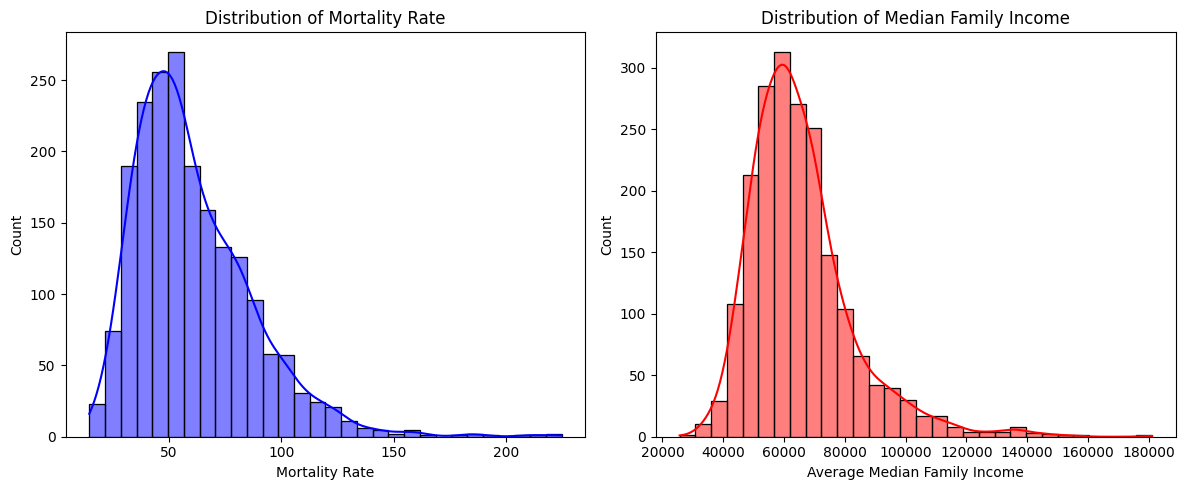

In [31]:
plt.figure(figsize=(12, 5))

# Mortality Rate Distribution
plt.subplot(1, 2, 1)
sns.histplot(df_cleaned['mortality_rate'], bins=30, kde=True, color="blue")
plt.xlabel("Mortality Rate")
plt.ylabel("Count")
plt.title("Distribution of Mortality Rate")

# Median Family Income Distribution
plt.subplot(1, 2, 2)
sns.histplot(df_cleaned['avg_median_family_income'], bins=30, kde=True, color="red")
plt.xlabel("Average Median Family Income")
plt.ylabel("Count")
plt.title("Distribution of Median Family Income")

plt.tight_layout()
plt.show()

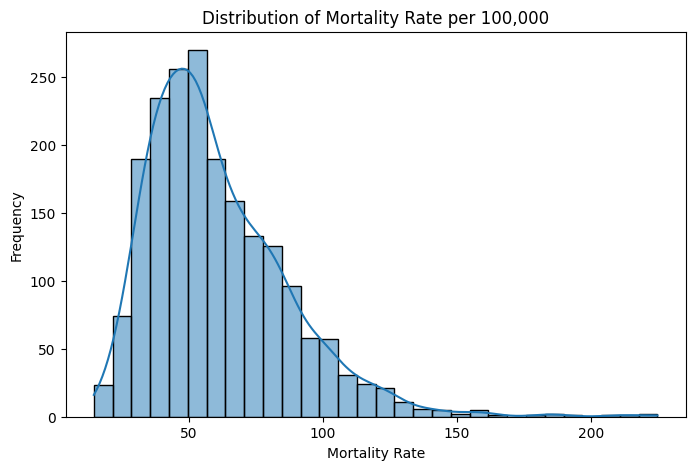

In [32]:
# Visualizes the distribution of mortality rates per 100,000 with a histogram and KDE.
plt.figure(figsize=(8, 5))
sns.histplot(df_cleaned['mortality_rate'], bins=30, kde=True)
plt.title("Distribution of Mortality Rate per 100,000")
plt.xlabel("Mortality Rate")
plt.ylabel("Frequency")
plt.show()

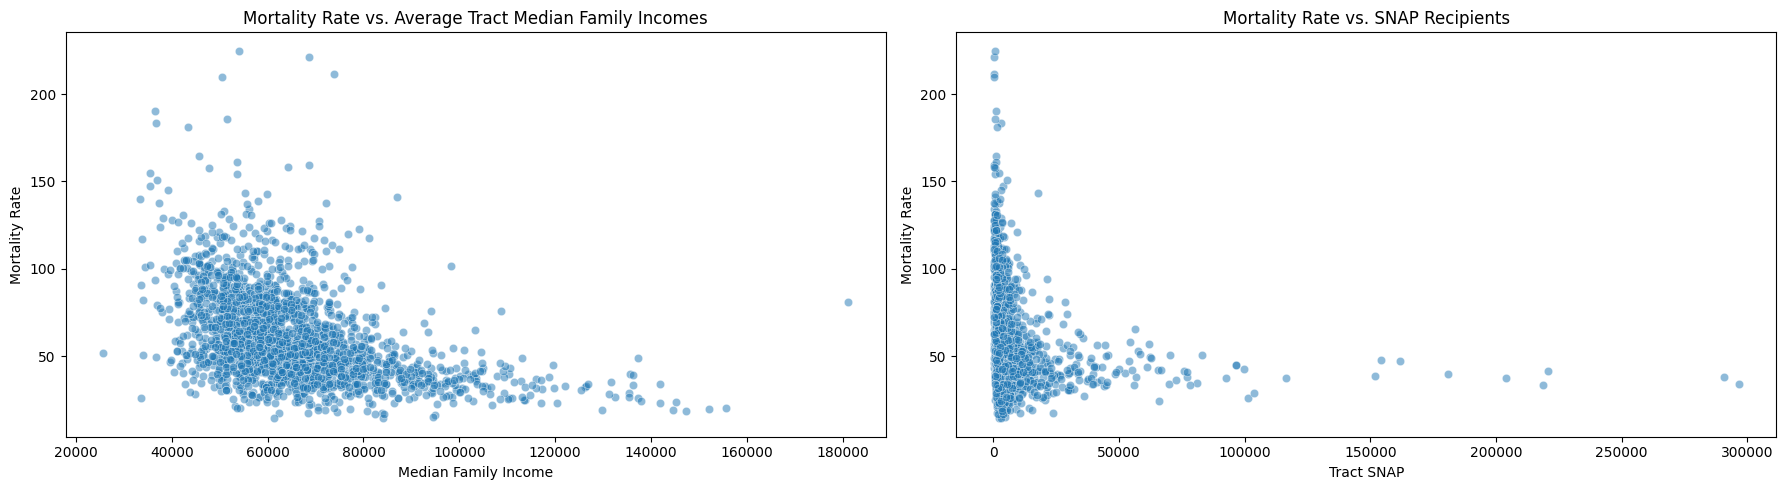

In [33]:
# Created scatter plots to visualize relationships between mortality rate and median family income, and mortality rate and SNAP recipients
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# mortality vs. median family income
sns.scatterplot(x=df_cleaned['avg_median_family_income'], y=df_cleaned['mortality_rate'], ax=axes[0], alpha=0.5)
axes[0].set_title("Mortality Rate vs. Average Tract Median Family Incomes")
axes[0].set_xlabel("Median Family Income")
axes[0].set_ylabel("Mortality Rate")

# mortality rate vs. SNAP recipients
sns.scatterplot(x=df_cleaned['total_TractSNAP'], y=df_cleaned['mortality_rate'], ax=axes[1], alpha=0.5)
axes[1].set_title("Mortality Rate vs. SNAP Recipients")
axes[1].set_xlabel("Tract SNAP")
axes[1].set_ylabel("Mortality Rate")

plt.tight_layout()
plt.show()


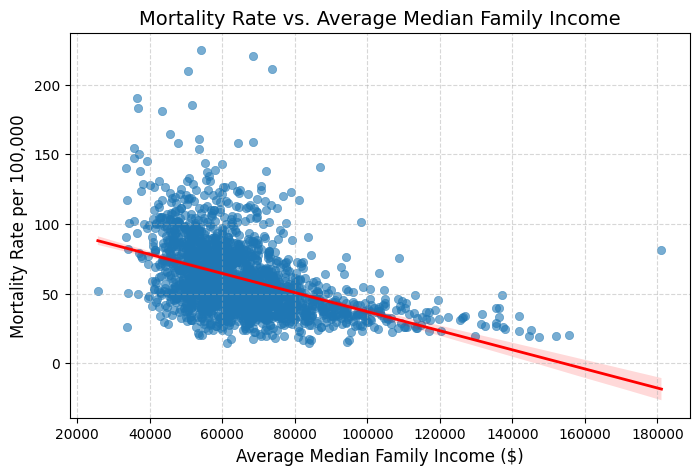

In [34]:
# Created scatter plot with a regression line to visualize the relationship between mortality rate and average median family income
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df_cleaned['avg_median_family_income'], y=df_cleaned['mortality_rate'], alpha=0.6, edgecolor=None)
sns.regplot(x=df_cleaned['avg_median_family_income'], y=df_cleaned['mortality_rate'], scatter=False, color='red', line_kws={"linewidth": 2})

plt.title("Mortality Rate vs. Average Median Family Income", fontsize=14)
plt.xlabel("Average Median Family Income ($)", fontsize=12)
plt.ylabel("Mortality Rate per 100,000", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

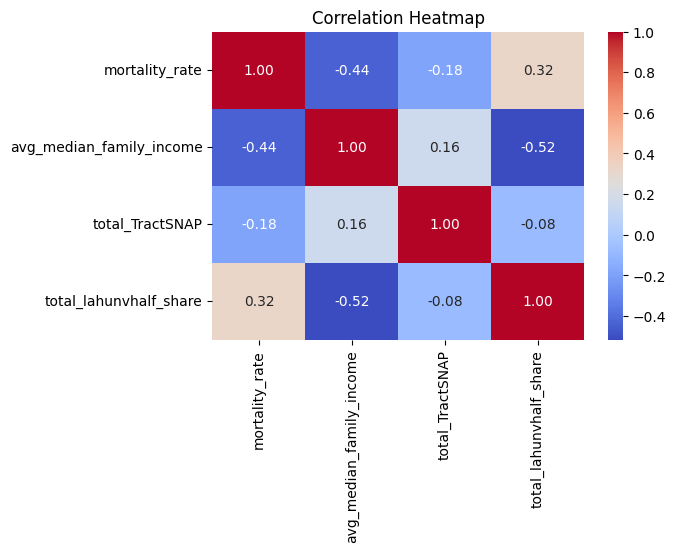

In [35]:
# Heatmap to visualize the correlation matrix of certain variables
corr_vars = ['mortality_rate', 'avg_median_family_income', 'total_TractSNAP', 'total_lahunvhalf_share']
corr_matrix = df_cleaned[corr_vars].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

/var/folders/7g/xw6rhgc51gzc64y3603lftr40000gn/T/ipykernel_18100/797872992.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_cleaned['food_access_indicator'], y=df_cleaned['mortality_rate'], palette=["red", "blue"])


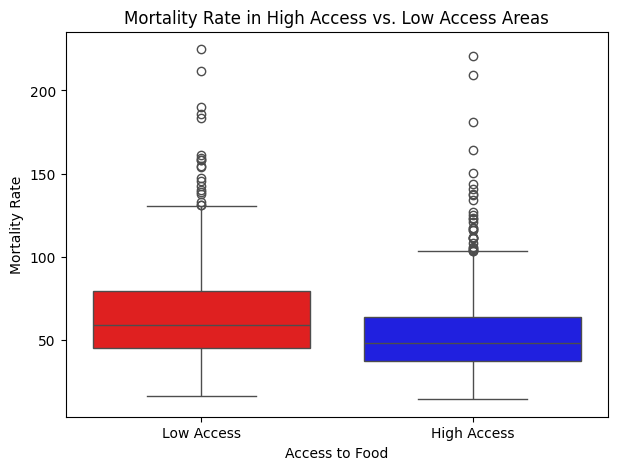

In [36]:
# Boxplot of Mortality Rate in High Access vs. Low Access counties 

plt.figure(figsize=(7, 5))
sns.boxplot(x=df_cleaned['food_access_indicator'], y=df_cleaned['mortality_rate'], palette=["red", "blue"])
plt.xticks(ticks=[0, 1], labels=["Low Access", "High Access"])  
plt.xlabel("Access to Food")
plt.ylabel("Mortality Rate")
plt.title("Mortality Rate in High Access vs. Low Access Areas")
plt.show()

In [37]:
# Grouping by 'food_access_indicator' and summarizing the mortality rate statistics
print(df_cleaned.groupby("food_access_indicator")["mortality_rate"].describe())

                        count       mean        std        min        25%  \
food_access_indicator                                                       
0                      1299.0  64.416608  26.382220  16.559755  45.032854   
1                       682.0  53.651939  24.817995  14.518327  37.351517   

                             50%        75%         max  
food_access_indicator                                    
0                      59.253407  79.442278  224.763022  
1                      48.200595  63.786636  220.896841  


### EDA Continued (Adam)

We next wanted to expolore how the 

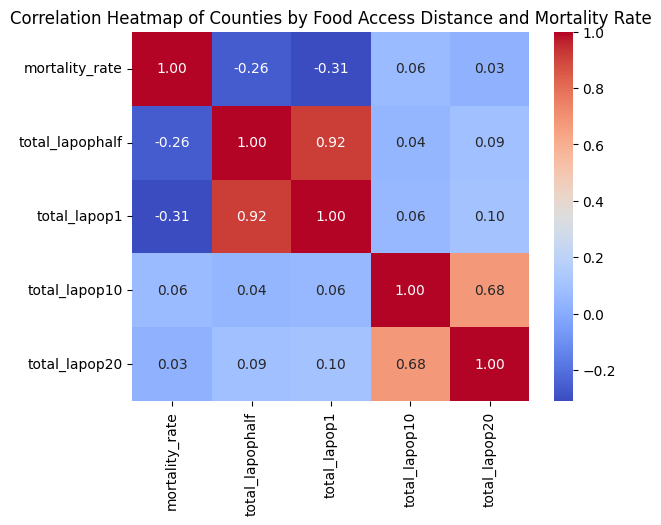

In [38]:
relevant_columns = ['mortality_rate', 'total_lapophalf',
                     'total_lapop1', 'total_lapop10', 'total_lapop20']
sns.heatmap(df_cleaned[relevant_columns].corr(), annot=True, cmap='coolwarm',fmt='.2f')
plt.title("Correlation Heatmap of Counties by Food Access Distance and Mortality Rate")
plt.show()

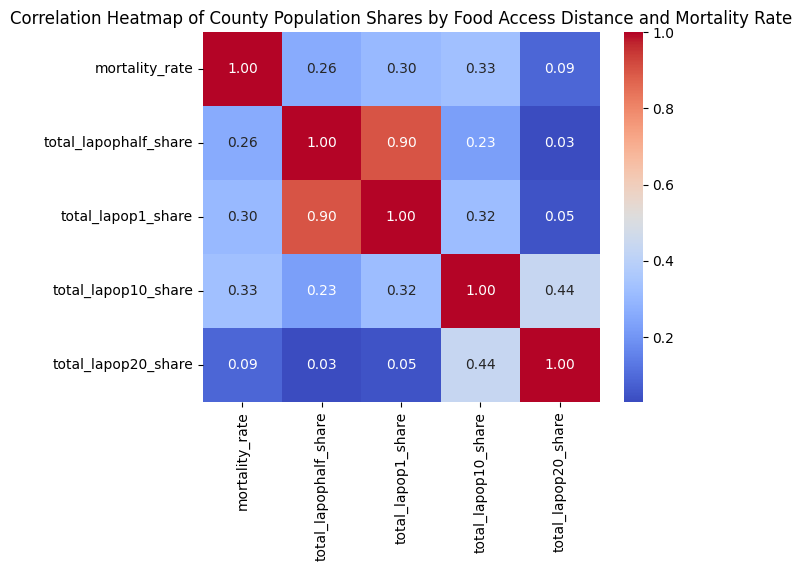

In [39]:
relevant_columns = ['mortality_rate', 'total_lapophalf_share', 
                    'total_lapop1_share', 'total_lapop10_share', 'total_lapop20_share']
sns.heatmap(df_cleaned[relevant_columns].corr(), annot=True, cmap='coolwarm',fmt='.2f')
plt.title("Correlation Heatmap of County Population Shares by Food Access Distance and Mortality Rate")
plt.show()

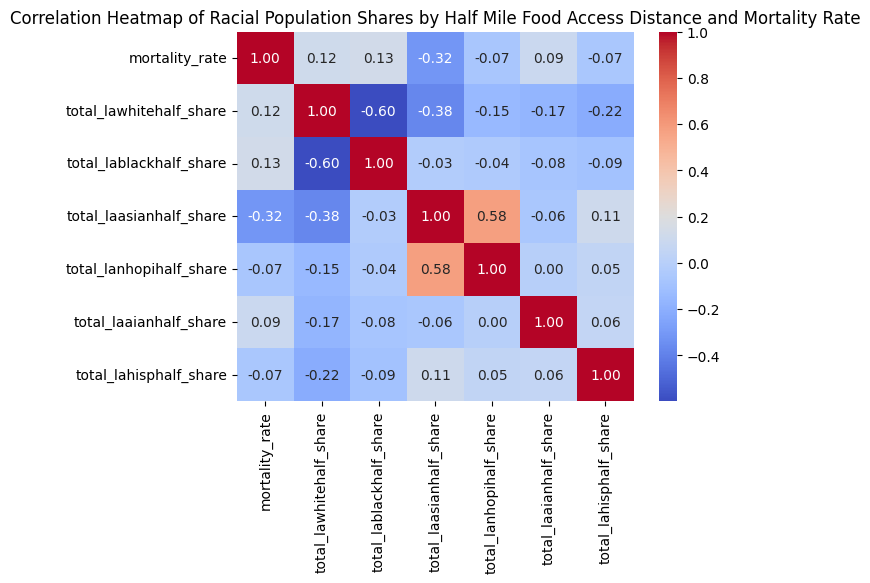

In [40]:
relevant_columns = ['mortality_rate', 'total_lawhitehalf_share', 'total_lablackhalf_share',
                    'total_laasianhalf_share', 'total_lanhopihalf_share', 'total_laaianhalf_share',
                    'total_lahisphalf_share']
sns.heatmap(df_cleaned[relevant_columns].corr(), annot=True, cmap='coolwarm',fmt='.2f')
plt.title("Correlation Heatmap of Racial Population Shares by Half Mile Food Access Distance and Mortality Rate")
plt.show()

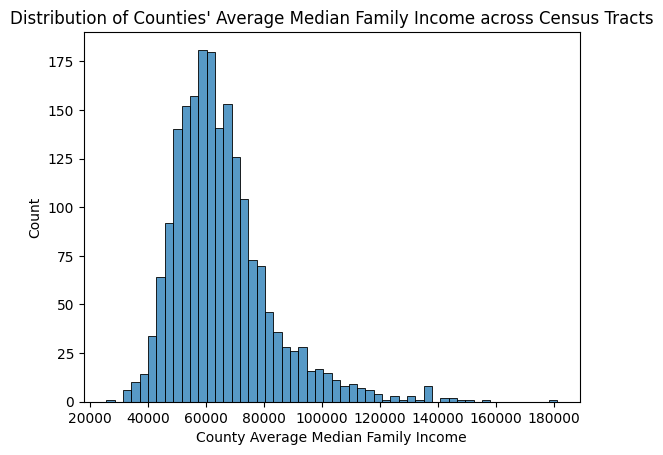

In [41]:
sns.histplot(df_cleaned['avg_median_family_income'])
plt.title("Distribution of Counties' Average Median Family Income across Census Tracts")
plt.xlabel('County Average Median Family Income')
plt.show()

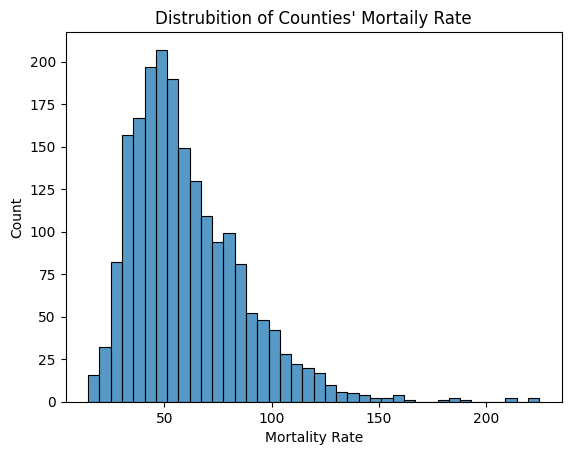

In [42]:
sns.histplot(df_cleaned['mortality_rate'])
plt.title("Distrubition of Counties' Mortaily Rate")
plt.xlabel('Mortality Rate')
plt.show()

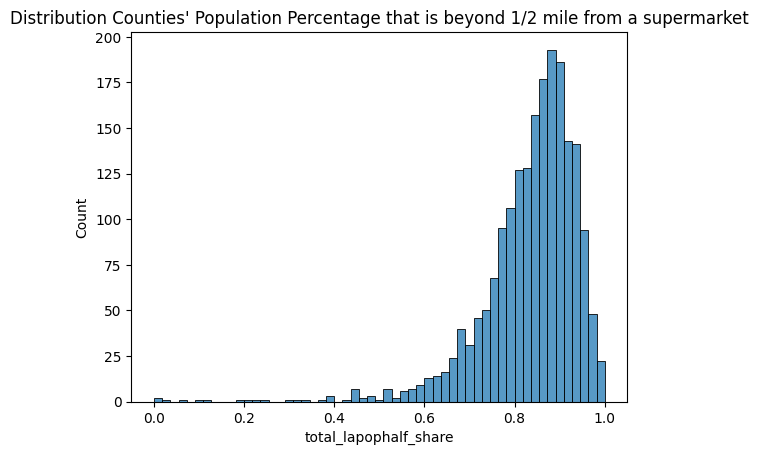

In [43]:
sns.histplot(df_cleaned['total_lapophalf_share'])
plt.title("Distribution Counties' Population Percentage that is beyond 1/2 mile from a supermarket")
plt.show()

In [44]:
df_cleaned_nandroped = df_cleaned.dropna(subset=['mortality_rate', 'total_lapophalf_share'])

# Compute Pearson correlation coefficient and p-value
corr, p_value = pearsonr(df_cleaned_nandroped['mortality_rate'], df_cleaned_nandroped['total_lapophalf_share'])

print(f"Pearson Correlation: {corr}")
print(f"P-value: {p_value}")

# Check significance
alpha = 0.05  # Common significance level (5%)
if p_value < alpha:
    print("The correlation is statistically significant.")
else:
    print("The correlation is NOT statistically significant.")


Pearson Correlation: 0.2585942453002774
P-value: 1.2454974446155588e-31
The correlation is statistically significant.


In [45]:
df_cleaned_nandroped = df_cleaned.dropna(subset=['mortality_rate', 'avg_median_family_income'])

# Compute Pearson correlation coefficient and p-value
corr, p_value = pearsonr(df_cleaned_nandroped['mortality_rate'], df_cleaned_nandroped['avg_median_family_income'])

print(f"Pearson Correlation: {corr}")
print(f"P-value: {p_value}")

# Check significance
alpha = 0.05  # Common significance level (5%)
if p_value < alpha:
    print("The correlation is statistically significant.")
else:
    print("The correlation is NOT statistically significant.")

Pearson Correlation: -0.4435579811025938
P-value: 3.2113295857416646e-96
The correlation is statistically significant.


## Hypothesis Testing

### Attempt at t-test (check for normal distribution and equal variance)

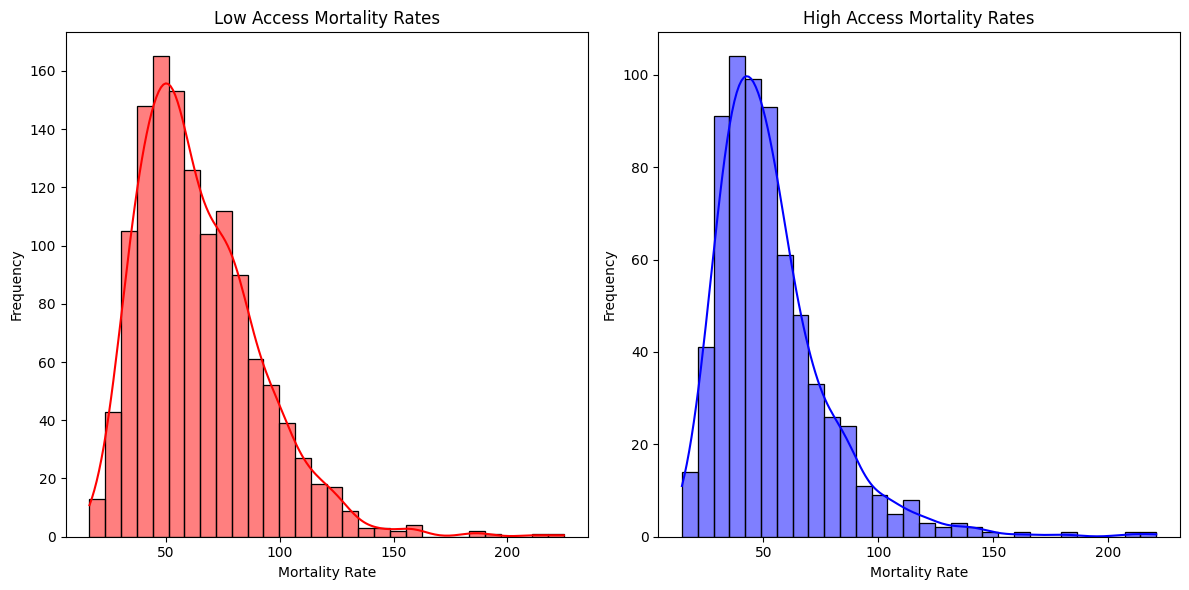

In [46]:
# Histograms comparing mortality rates in low and high food access areas
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_cleaned[df_cleaned['food_access_indicator'] == 0]['mortality_rate'], bins=30, kde=True, color='red')
plt.title("Low Access Mortality Rates")
plt.xlabel("Mortality Rate")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.histplot(df_cleaned[df_cleaned['food_access_indicator'] == 1]['mortality_rate'], bins=30, kde=True, color='blue')
plt.title("High Access Mortality Rates")
plt.xlabel("Mortality Rate")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

### QQ plots of low vs high food access areas

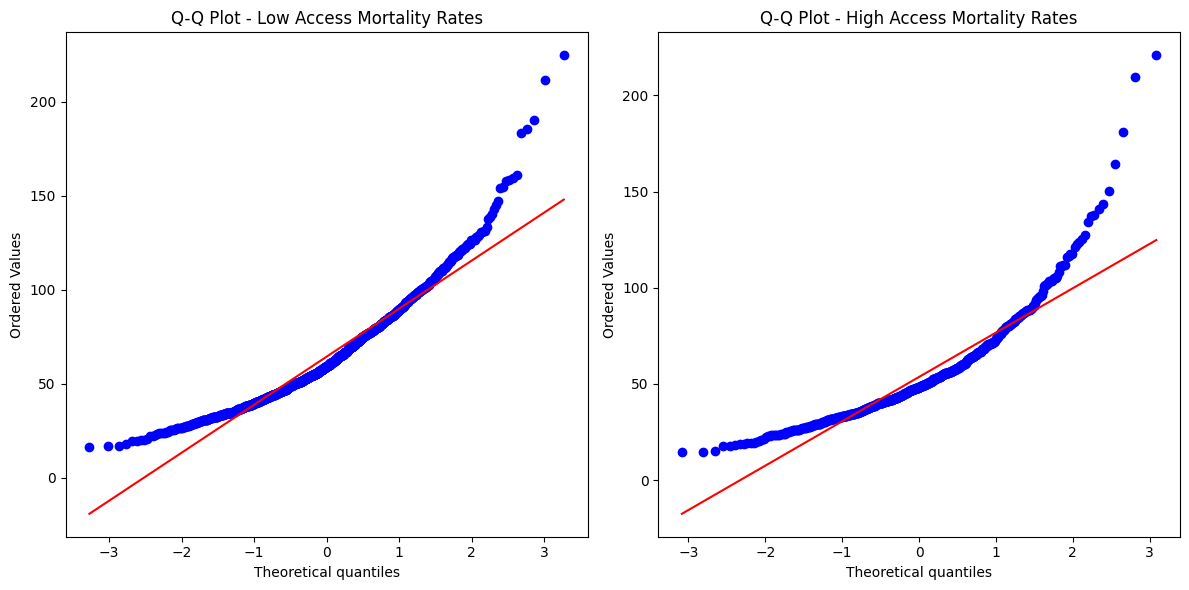

In [47]:
# Q-Q plots to assess the normality of mortality rates in low and high food access areas
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
stats.probplot(df_cleaned[df_cleaned['food_access_indicator'] == 0]['mortality_rate'], dist="norm", plot=plt)
plt.title("Q-Q Plot - Low Access Mortality Rates")

plt.subplot(1, 2, 2)
stats.probplot(df_cleaned[df_cleaned['food_access_indicator'] == 1]['mortality_rate'], dist="norm", plot=plt)
plt.title("Q-Q Plot - High Access Mortality Rates")

plt.tight_layout()
plt.show()

### Kolmogorov-Smirnov (KS) test

In [48]:
# KS test to compare the distribution of mortality rates between high and low food access groups
high_food_access_group = df_cleaned[df_cleaned['food_access_indicator'] == 1]['mortality_rate']
low_food_access_group = df_cleaned[df_cleaned['food_access_indicator'] == 0]['mortality_rate']

statistic, p_value = ks_2samp(high_food_access_group, low_food_access_group)

print(f"KS Test statistic: {statistic}, p-value: {p_value}")

KS Test statistic: 0.21065493646138808, p-value: 7.224501751217153e-18


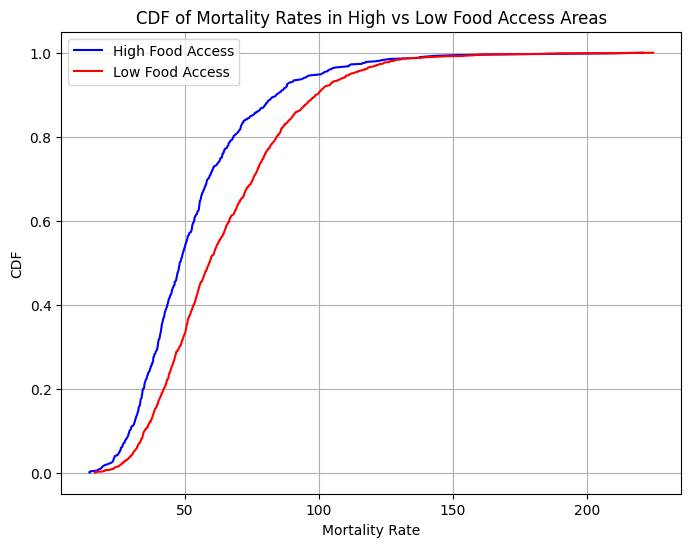

In [49]:
# Visualizing CDF of mortality rates for high and low food access areas
high_food_access_group = df_cleaned[df_cleaned['food_access_indicator'] == 1]['mortality_rate']
low_food_access_group = df_cleaned[df_cleaned['food_access_indicator'] == 0]['mortality_rate']

high_food_access_sorted = np.sort(high_food_access_group)
low_food_access_sorted = np.sort(low_food_access_group)

high_food_access_cdf = np.arange(1, len(high_food_access_sorted)+1) / len(high_food_access_sorted)
low_food_access_cdf = np.arange(1, len(low_food_access_sorted)+1) / len(low_food_access_sorted)

plt.figure(figsize=(8, 6))
plt.plot(high_food_access_sorted, high_food_access_cdf, label='High Food Access', color='blue')
plt.plot(low_food_access_sorted, low_food_access_cdf, label='Low Food Access', color='red')
plt.xlabel('Mortality Rate')
plt.ylabel('CDF')
plt.title('CDF of Mortality Rates in High vs Low Food Access Areas')
plt.legend()
plt.grid(True)
plt.show()

### Permutation Test

In [50]:
# Combining mortality rate data for high and low food access groups into a single DataFrame with labels for each group
high_food_access_group = df_cleaned[df_cleaned['food_access_indicator'] == True]['mortality_rate']
low_food_access_group = df_cleaned[df_cleaned['food_access_indicator'] == False]['mortality_rate']

combined_mortality_rate = np.concatenate([high_food_access_group.values, low_food_access_group.values])
labels = np.concatenate([np.ones(len(high_food_access_group)), np.zeros(len(low_food_access_group))])
combined_df = pd.DataFrame({'mortality_rate': combined_mortality_rate, 'is_high_food_access': labels})
combined_df.head()

,mortality_rate,is_high_food_access
0,64.136629,1.0
1,30.361299,1.0
2,38.583082,1.0
3,53.624437,1.0
4,46.927252,1.0


In [51]:
# Performing a permutation test to compare the means of mortality rates between high and low food access groups

high_food_access_group = combined_df[combined_df['is_high_food_access'] == 1]['mortality_rate']
low_food_access_group = combined_df[combined_df['is_high_food_access'] == 0]['mortality_rate']

observed_diff = high_food_access_group.mean() - low_food_access_group.mean()
combined_data = np.concatenate([high_food_access_group, low_food_access_group])
n_permutations = 10000
permuted_diffs = []

for _ in range(n_permutations):
    permuted_data = np.random.permutation(combined_data) 
    perm_high_food_access = permuted_data[:len(high_food_access_group)]  
    perm_low_food_access = permuted_data[len(high_food_access_group):]
    perm_diff = perm_high_food_access.mean() - perm_low_food_access.mean()
    permuted_diffs.append(perm_diff)
permuted_diffs = np.array(permuted_diffs)

# Calculating the p-value to test if the observed difference in means is statistically significant
p_value = np.mean(np.abs(permuted_diffs) >= np.abs(observed_diff))

print(f"Observed difference in means: {observed_diff}")
print(f"Permutation test p-value: {p_value}")

Observed difference in means: -10.764668907420216
Permutation test p-value: 0.0


With a consistent p-value of 0, we reject our null hypothesis. The difference in mortality rates between food desert and non-food desert areas is statistically significant. 

## Regression Modeling

We want to take a deeper look into the key risk factors that contribute to the highest county-wide mortality rates in our data. To accomplish this, we can contruct a regression model with an optimal set of variables to predict the mortality rate. This model can potentially give us insight on what populations suffer the most from food deserts and how to focus public health efforts to reduce food insecurity among US counties.

In [72]:
import scipy.stats as stats
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Interested Variables

In [74]:
df_cleaned

,Deaths,avg_median_family_income,total_Urban,total_Pop2010,total_OHU2010,total_NUMGQTRS,total_PCTGQTRS,total_LILATracts_1And10,total_LILATracts_halfAnd10,total_LILATracts_1And20,...,total_TractWhite_share,total_TractBlack_share,total_TractAsian_share,total_TractNHOPI_share,total_TractAIAN_share,total_TractOMultir_share,total_TractHispanic_share,total_TractHUNV_share,total_TractSNAP_share,mortality_rate
County_State,,,,,,,,,,,,,,,,,,,,,
"Autauga County, AL",35,69337.500000,7,54571,20221,455.0,12.853691,5,5,3,...,0.785307,0.176706,0.008686,0.000586,0.004251,0.024464,0.024005,0.021825,0.049330,64.136629
"Baldwin County, AL",108,72665.741935,14,182265,73180,2307.0,41.062742,4,4,3,...,0.856736,0.093847,0.007396,0.000488,0.006672,0.034861,0.043848,0.014841,0.032513,59.254382
"Barbour County, AL",11,44792.444444,2,27457,9820,3193.0,79.735470,4,5,1,...,0.480023,0.468915,0.003897,0.001056,0.004152,0.041957,0.050515,0.030921,0.091634,40.062643
"Blount County, AL",18,60437.666667,1,57322,21578,489.0,7.248861,0,0,0,...,0.925788,0.013276,0.002041,0.000663,0.005356,0.052877,0.080702,0.014933,0.034297,31.401556
"Butler County, AL",24,50170.666667,2,20947,8491,333.0,11.934450,3,3,1,...,0.544183,0.434191,0.008450,0.000334,0.002864,0.009978,0.009118,0.024825,0.059579,114.574879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Laramie County, WY",51,77803.500000,17,91738,37576,1644.0,43.313942,4,4,4,...,0.885184,0.024505,0.010639,0.001548,0.009571,0.068554,0.130567,0.020068,0.029889,55.593102
"Natrona County, WY",39,77146.666667,12,75450,30616,1645.0,44.988999,1,2,1,...,0.927966,0.008814,0.006759,0.000517,0.010351,0.045593,0.069331,0.017389,0.029304,51.689861
"Park County, WY",11,75257.200000,4,28205,11885,942.0,15.673829,0,0,0,...,0.955540,0.001985,0.005885,0.000886,0.005956,0.029746,0.048396,0.015706,0.020989,39.000177


There are over 180 variables associated with each county in our cleaned, merged dataset, so we need to cut down and focus just on the variables we are most interested in. We identified the following 15 variables to include in our model, based on their description and correlation matrix defined above in the exploratory data analysis section. Intuitively, these variables can shed valuable insight on the nutritional and metabolic mortality rate in these US counties. Naturally, our dataset contains null values in many of the columns. We plan to use imputation to address these missing values, but the effects of imputation are typically only useful when the feature is missing less than around 10% of its values. As such, we focused our features to have less than 10% missing values to be able to apply imputation.

The variables are described as follows:

1. 'avg_median_family_income'
2. 'lapophalf_new'
3. 'lalowihalf_new'
4. 'lawhitehalf_new'
5. 'lablackhalf_new'
6. 'laasianhalf_new'
7. 'lanhopihalf_new'
8. 'laaianhalf_new',
9. 'lahisphalf_new'
10. 'lahunvhalf_new'
11. 'total_population'

The response variable 'mortality_rate' is a continuous quantitative data type, which is the crude mortality rate due to nutritional and metabolic diseases per 100,000 in a given US county.

In [76]:
interested_variables = [
    'avg_median_family_income', 'total_lapophalf_share', 
    'total_lalowihalf_share',
    'total_lawhitehalf_share', 'total_lablackhalf_share',
    'total_laasianhalf_share', 'total_laaianhalf_share',
    'total_lahisphalf_share', 
    'total_lahunvhalf_share', 'total_Pop2010', 'mortality_rate'
]

As shown, each of our 14 interested variables have missing counts that are less than 10% of the entire dataset.

In [78]:
for feature in interested_variables:
    missing_count=df_cleaned[feature].isna().sum()
    print(f'Missing values for feature {feature}:', missing_count, f'({np.round(missing_count/df_cleaned.shape[0], decimals=2)}% missing)')

Missing values for feature avg_median_family_income: 1 (0.0% missing)
Missing values for feature total_lapophalf_share: 0 (0.0% missing)
Missing values for feature total_lalowihalf_share: 0 (0.0% missing)
Missing values for feature total_lawhitehalf_share: 0 (0.0% missing)
Missing values for feature total_lablackhalf_share: 0 (0.0% missing)
Missing values for feature total_laasianhalf_share: 0 (0.0% missing)
Missing values for feature total_laaianhalf_share: 0 (0.0% missing)
Missing values for feature total_lahisphalf_share: 0 (0.0% missing)
Missing values for feature total_lahunvhalf_share: 0 (0.0% missing)
Missing values for feature total_Pop2010: 0 (0.0% missing)
Missing values for feature mortality_rate: 0 (0.0% missing)


In [79]:
# Drop 1 missing value and create df for regression
df_reg_var = df_cleaned.loc[:, interested_variables].dropna()
df_reg_var.head()

,avg_median_family_income,total_lapophalf_share,total_lalowihalf_share,total_lawhitehalf_share,total_lablackhalf_share,total_laasianhalf_share,total_laaianhalf_share,total_lahisphalf_share,total_lahunvhalf_share,total_Pop2010,mortality_rate
County_State,,,,,,,,,,,
"Autauga County, AL",69337.500000,0.907045,0.284362,0.709159,0.164699,0.006841,0.003958,0.021368,0.019133,54571,64.136629
"Baldwin County, AL",72665.741935,0.908675,0.263985,0.782021,0.082056,0.006344,0.006216,0.040153,0.011952,182265,59.254382
"Barbour County, AL",44792.444444,0.865444,0.433441,0.430836,0.388772,0.002695,0.003968,0.046319,0.027043,27457,40.062643
"Blount County, AL",60437.666667,0.958304,0.345547,0.889136,0.012482,0.001851,0.005162,0.074355,0.014337,57322,31.401556
"Butler County, AL",50170.666667,0.862436,0.412879,0.484572,0.358852,0.006969,0.002787,0.008545,0.025840,20947,114.574879


### Transforming Data 

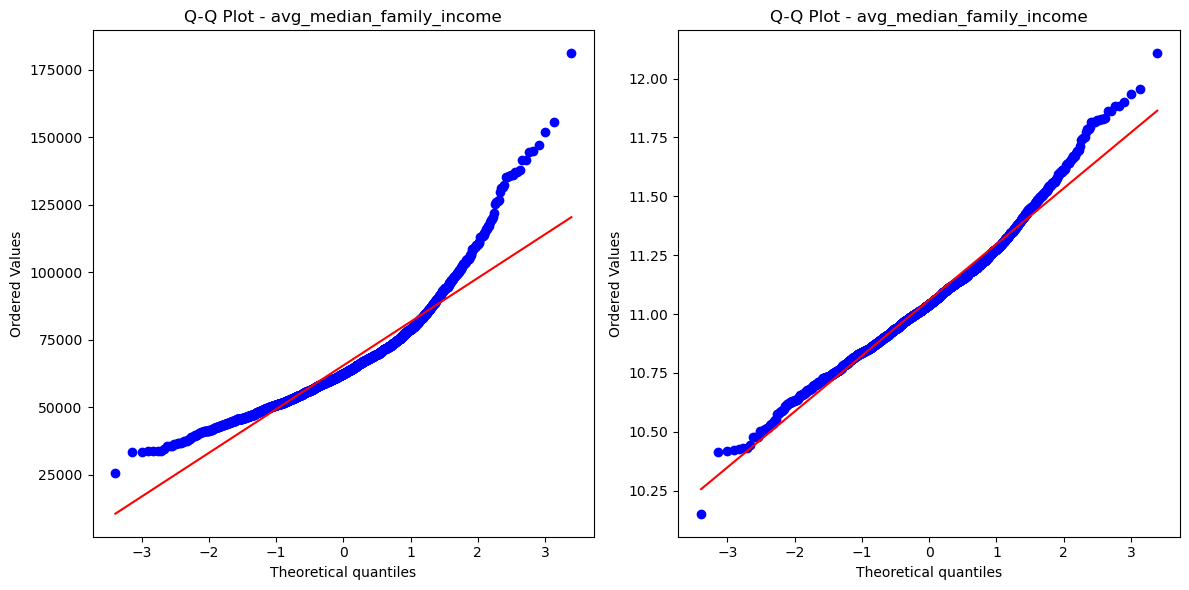

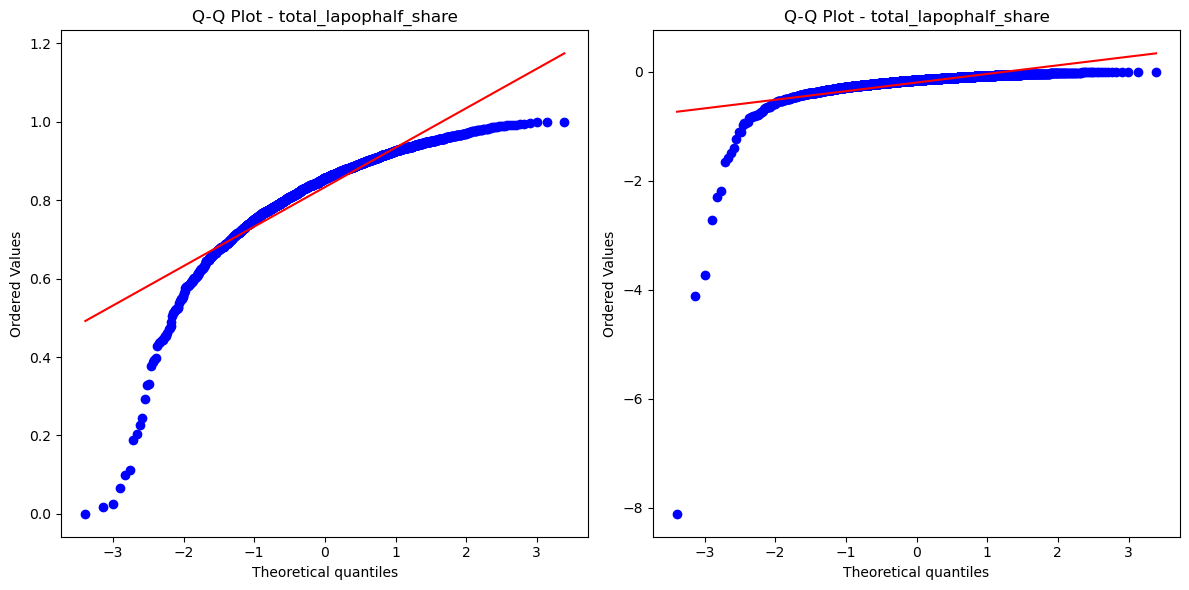

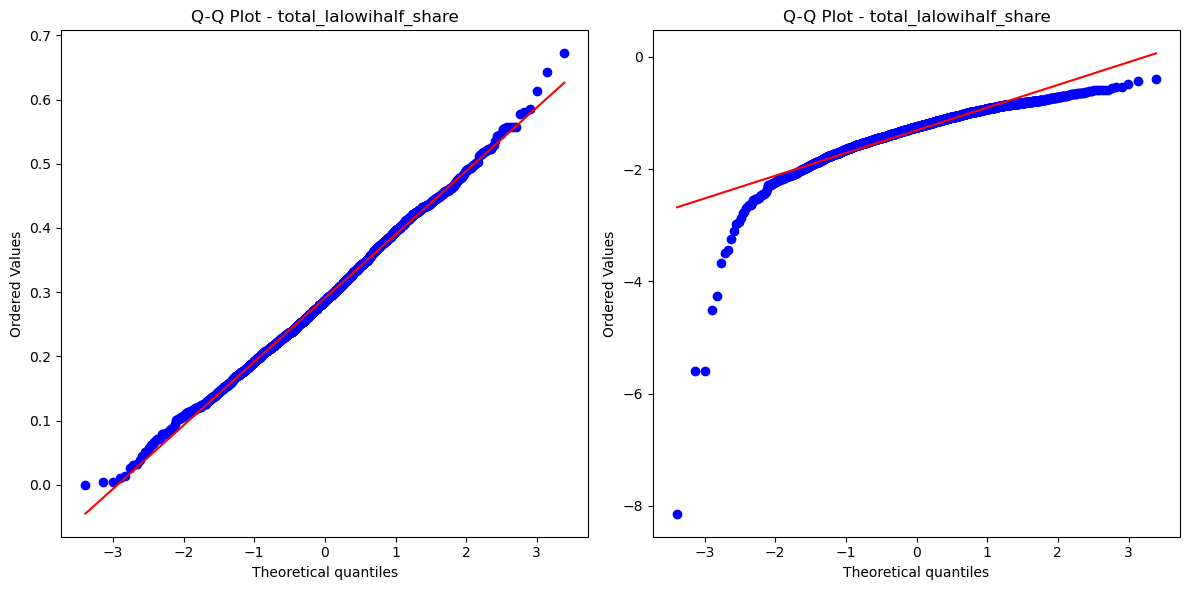

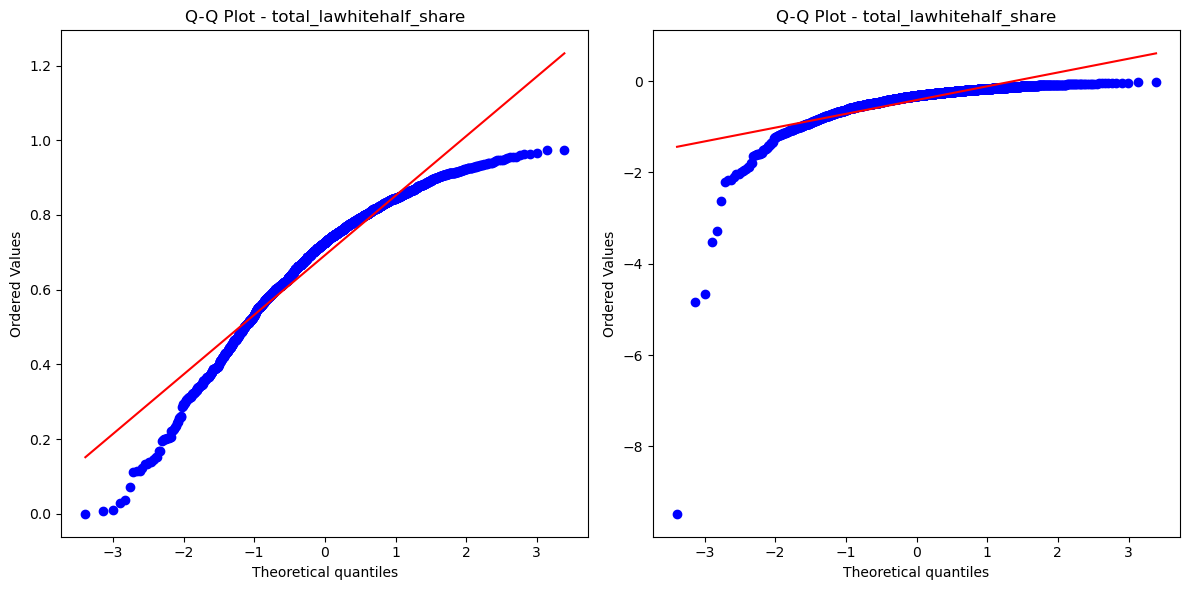

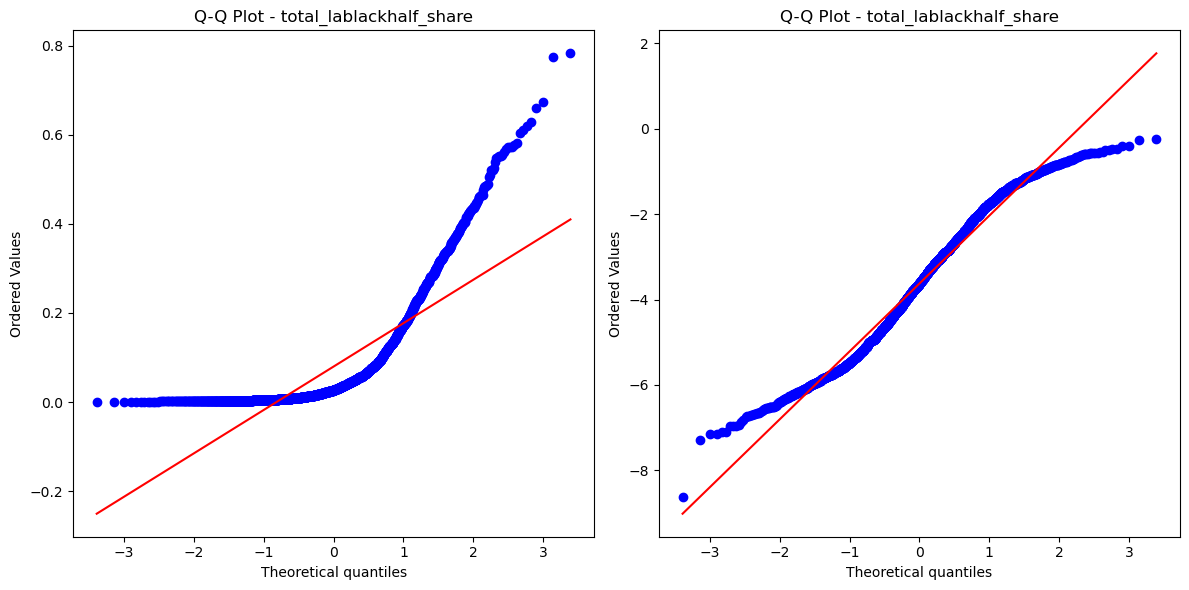

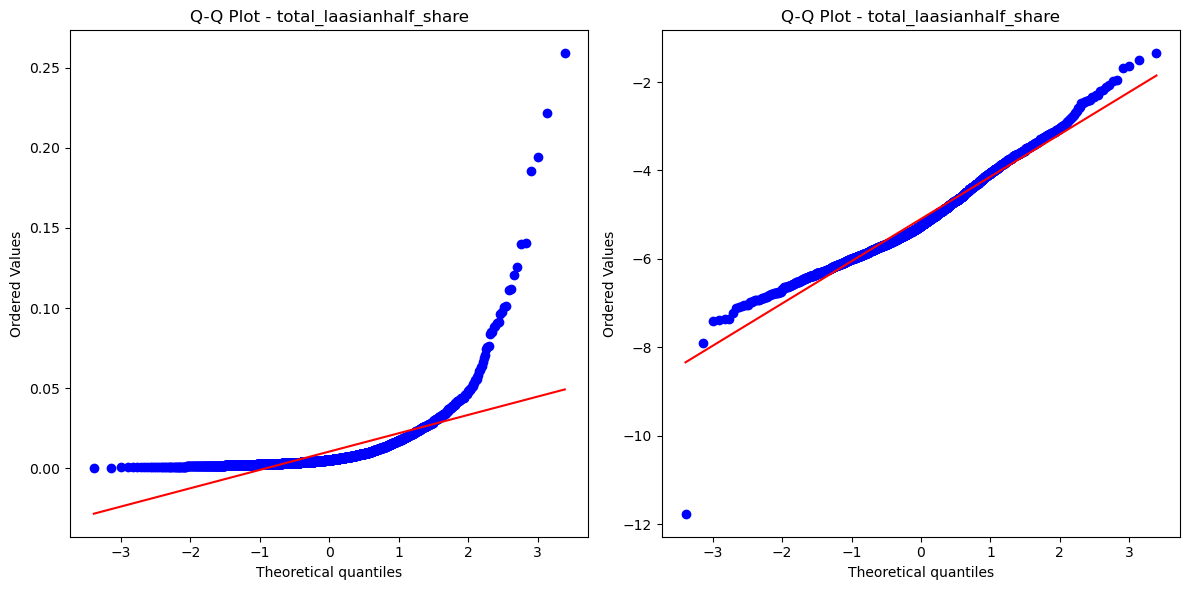

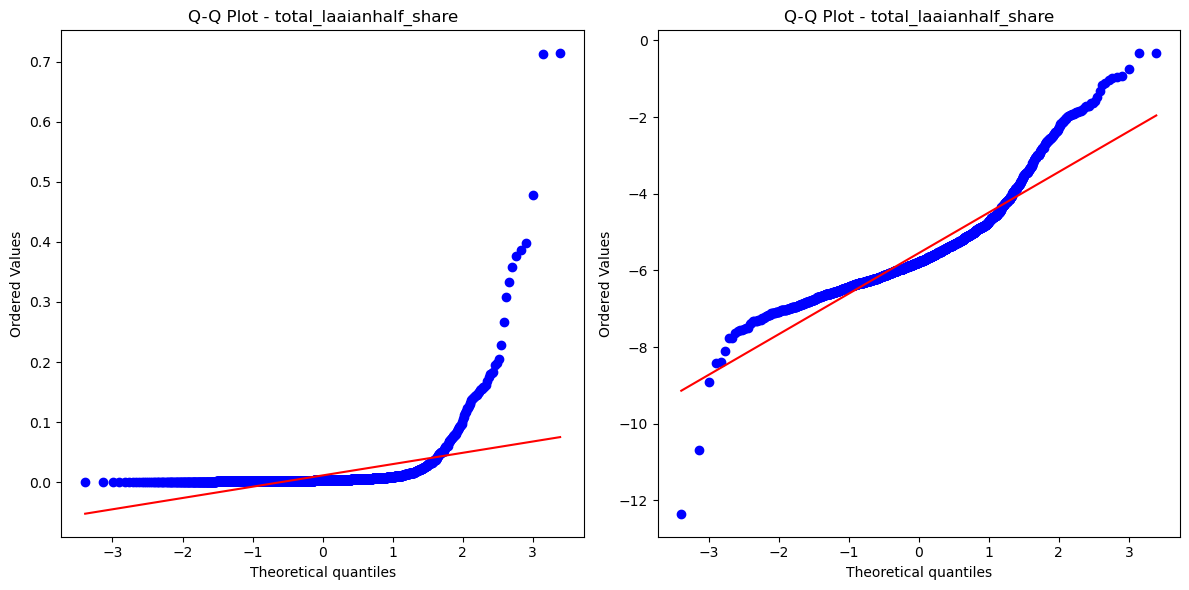

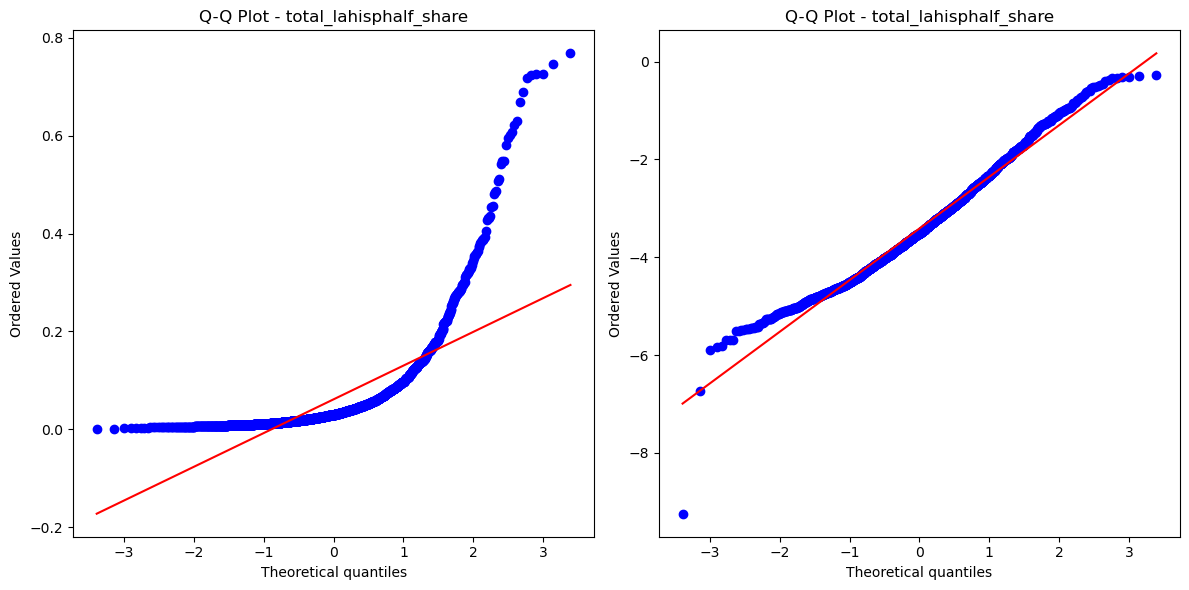

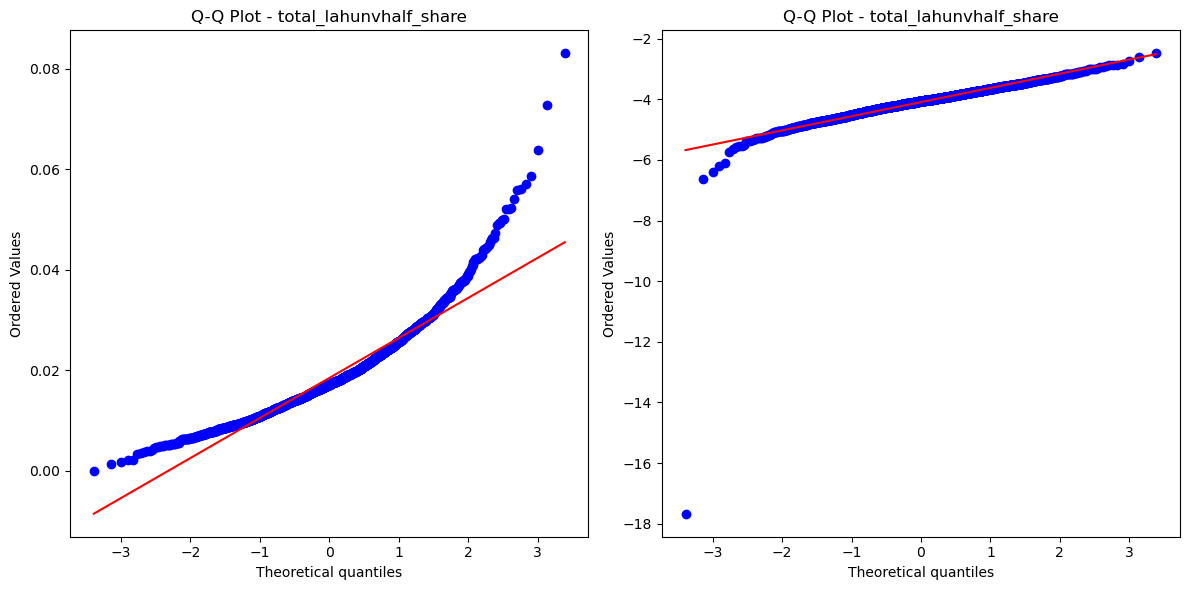

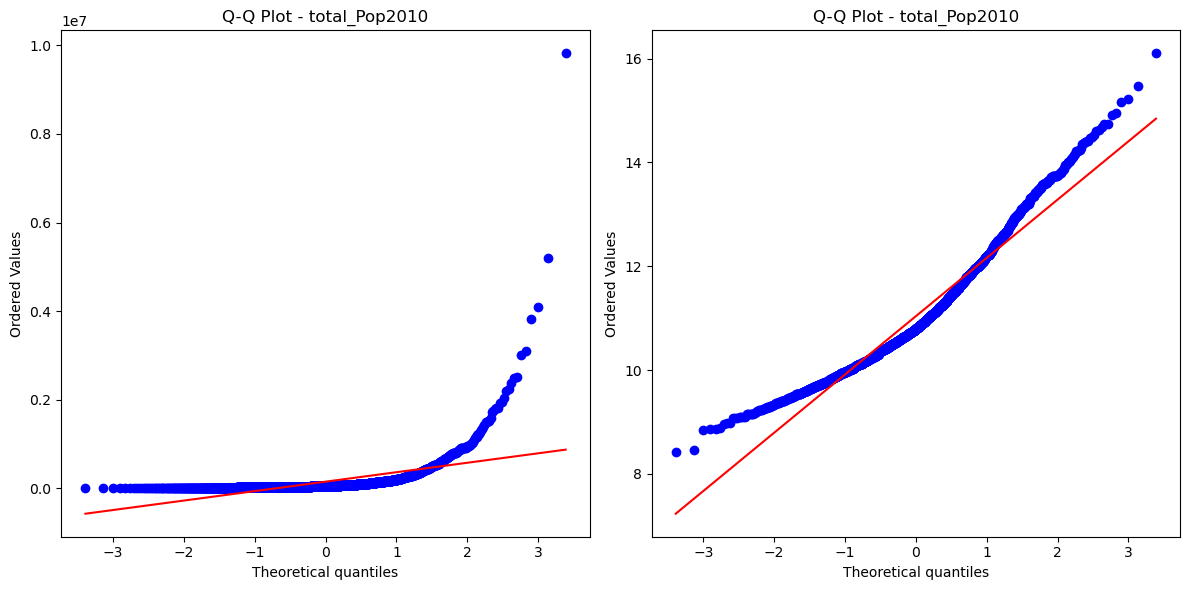

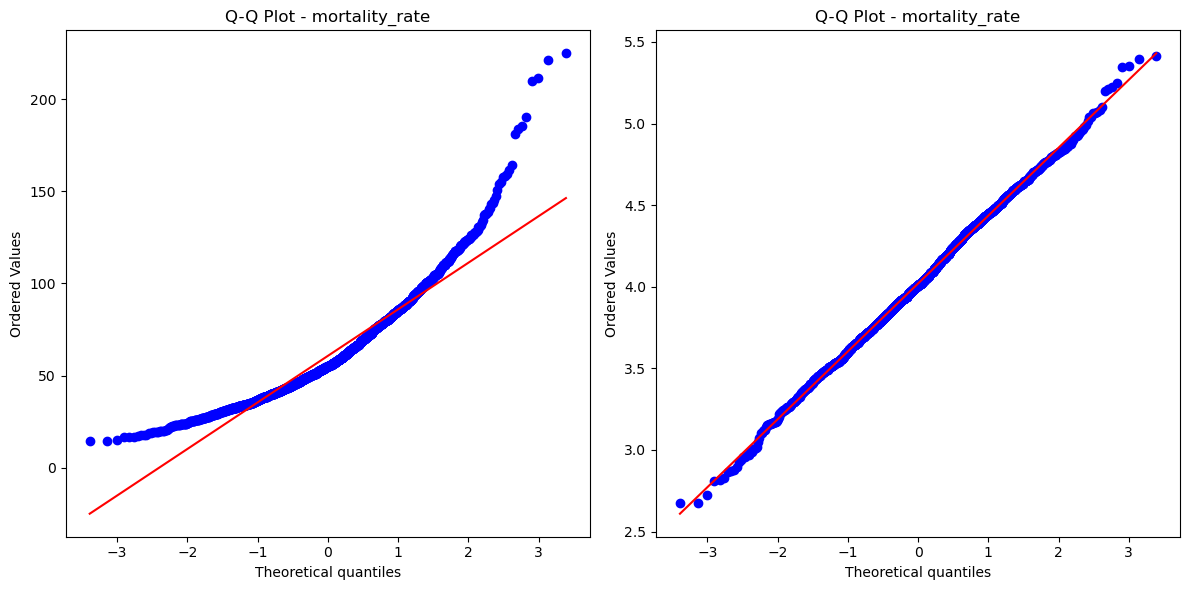

In [81]:
for var in interested_variables:
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    stats.probplot(df_reg_var[var], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot - {var}")

    plt.subplot(1, 2, 2)
    stats.probplot(np.log(df_reg_var[var]), dist="norm", plot=plt)
    plt.title(f"Q-Q Plot - {var}")

    plt.tight_layout()
    plt.show()

In [82]:
# Apply a log to all of the intrested variables for a more normal dist
df_reg_trans = np.log(df_reg_var)

### Split Data

To test the performance of our model, we can set up a train/test/split process and divide our data into the training set (80%) and test set (20%). Ultimately, the model will be evaluated on data it has not seen before, providing a performance metric on its ability to generalize to new data.

In [85]:
# Split Data
X = df_reg_trans.drop(columns=['mortality_rate'])
X = X.copy()

y = df_reg_trans['mortality_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model

We can apply our transformations to our train and test sets. We then convert our transformed features back into a DataFrame to be able to use the StatsModels OLS regression model.

In [88]:
X_train

,avg_median_family_income,total_lapophalf_share,total_lalowihalf_share,total_lawhitehalf_share,total_lablackhalf_share,total_laasianhalf_share,total_laaianhalf_share,total_lahisphalf_share,total_lahunvhalf_share,total_Pop2010
County_State,,,,,,,,,,
"Cochise County, AZ",10.913262,-0.135642,-1.093224,-0.366136,-3.313148,-4.078287,-4.577589,-1.356906,-4.080353,11.785590
"Baker County, FL",11.155254,-0.048959,-1.129451,-0.216477,-2.118486,-5.325734,-5.984754,-3.997615,-5.195359,10.207842
"Emmet County, MI",11.141287,-0.210884,-1.474407,-0.280044,-5.636348,-5.523186,-3.613966,-4.650349,-4.331813,10.394947
"Montgomery County, KY",10.889805,-0.095838,-0.876033,-0.150708,-3.721679,-5.861763,-6.367153,-3.841072,-3.910185,10.184862
"Putnam County, GA",10.976693,-0.067319,-0.952400,-0.435627,-1.457906,-5.360521,-6.411212,-2.838124,-4.050634,9.962605
...,...,...,...,...,...,...,...,...,...,...
"Burke County, NC",10.893669,-0.094441,-0.982097,-0.250542,-2.839844,-3.401733,-5.824277,-3.356086,-4.110377,11.417647
"Summit County, OH",11.149320,-0.285937,-1.514602,-0.483657,-2.314872,-4.123303,-6.630442,-4.513887,-3.734654,13.202617
"Swift County, MN",11.102232,-0.370369,-1.661642,-0.398678,-5.914612,-6.888402,-6.616883,-3.687319,-4.507744,9.188401


Here, we create the formula with all of our features and run the OLS regression model on our transformed, training set. This represents the full model, which will likely not be the final, optimal model we will end up using to model our data. From the OLS regression results summary, we can observe that none of the coefficents of our variables, including the interept term, are statistically significant.

In [90]:
# Perform OLS regression with statsmodels formula API (use DataFrame for formula)
X_train['mortality_rate'] = y_train

# Fit the initial OLS model with all features
formula = 'mortality_rate ~ ' + ' + '.join(X_train.columns.drop('mortality_rate'))

In [91]:
# Fit the final model with the selected features
final_model = smf.ols(formula, X_train).fit()

# Check the summary of the model
print(final_model.summary())

                            OLS Regression Results                            
Dep. Variable:         mortality_rate   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     95.83
Date:                Sat, 15 Mar 2025   Prob (F-statistic):          1.05e-154
Time:                        12:07:09   Log-Likelihood:                -476.04
No. Observations:                1584   AIC:                             974.1
Df Residuals:                    1573   BIC:                             1033.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [92]:
def criterion(formula, df):
    """
    Calculate the BIC for a given regression model formula and given dataframe.

    Parameters:
    formula (str): The regression model formula.
    df (pandas.DataFrame): The dataframe containing the data.

    Returns:
    float: The BIC value of the fitted model.
    """
    model = smf.ols(formula, df).fit()
    criterion_value = model.bic
    return criterion_value

def remove(df, already_selected_columns, criterion, response='y'):
    """
    Identify the worst column to remove based on the given criterion.
    REMEMBER: The smaller the criterion, the better the model.

    Parameters:
    df (pandas.DataFrame): The dataframe containing the data.
    already_selected_columns (set): The set of currently selected columns.
    criterion (function): The criterion function to evaluate the model.
    response (str): The response variable name.

    Returns:
    tuple: The worst column to remove and its criterion value.
    """

    # initialize the worst criterion and column to None
    worst_criterion = float('inf')
    worst_column = None

    # iterate over the already selected columns to find the worst column to remove
    for column in already_selected_columns:
        new_columns = already_selected_columns - {column}
        formula = f'{response} ~ {" + ".join(new_columns)}'
        current_criterion = criterion(formula, df)
        if current_criterion < worst_criterion:
            worst_criterion = current_criterion
            worst_column = column
    return worst_column, worst_criterion

def backward(df, criterion, response='y'):
    """
    Perform backward selection to find the optimal model based on the given criterion.
    REMEMBER: The smallest criterion value is considered the best model fit.
    
    Parameters:
    df (pandas.DataFrame): The dataframe containing the data.
    criterion (function): The criterion function to evaluate the model.
    response (str): The response variable name.

    Returns:
    set: The set of selected columns in the optimal model.
    """

    # initialize the set of already selected columns to all columns except the response variable
    already_selected_columns = set(df.columns.drop(response))
    best_criterion = criterion(f'{response} ~ {' + '.join(already_selected_columns)}', df)
    while len(already_selected_columns) > 0:

        # identify the worst column to remove based on the given criterion
        potential_column, current_criterion = remove(df, already_selected_columns, criterion, response)

        # check if the model with the worst column removed has a better criterion value
        if current_criterion <= best_criterion:
            already_selected_columns.remove(potential_column)
            best_criterion = current_criterion
            print(f'Criterion: {best_criterion}')
        else:
            break
    final_selection = already_selected_columns
    return final_selection

In [93]:
backward_vars = backward(X_train, criterion, response='mortality_rate')
backward_vars

Criterion: 1025.9498611911283
Criterion: 1019.1317910285813
Criterion: 1013.7411974354857
Criterion: 1011.6342021043536
Criterion: 1006.0008457120346
Criterion: 1005.5930035342354


{'avg_median_family_income',
 'total_Pop2010',
 'total_laasianhalf_share',
 'total_lahunvhalf_share'}

In [94]:
# Fit the final model with the selected features
final_formula = 'mortality_rate ~ ' + ' + '.join(backward_vars)
final_model = smf.ols(final_formula, X_train).fit()

# Check the summary of the model
print(final_model.summary())

                            OLS Regression Results                            
Dep. Variable:         mortality_rate   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     233.8
Date:                Sat, 15 Mar 2025   Prob (F-statistic):          9.10e-158
Time:                        12:07:09   Log-Likelihood:                -484.38
No. Observations:                1584   AIC:                             978.8
Df Residuals:                    1579   BIC:                             1006.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

#### Interpretation of the coefficients

$e^\beta - 1$ 

### Evaluate Model

In [98]:
# Step 6: Make predictions on both training and test sets
train_predictions = final_model.predict(X_train)
test_predictions = final_model.predict(X_test)

# Step 7: Calculate RMSE for both training and test sets
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

print("Training RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

Training RMSE: 0.32852418304741166
Test RMSE: 0.33647111176037986


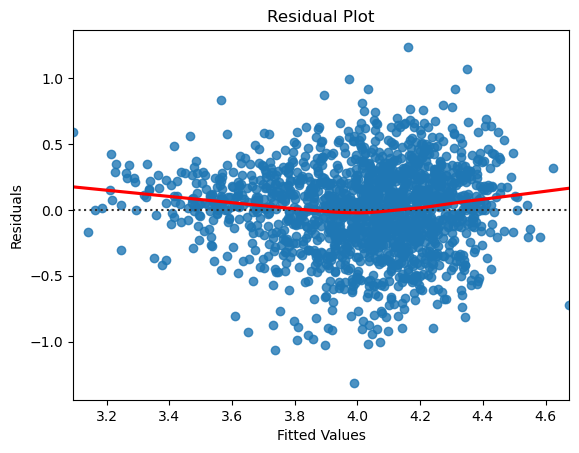

In [99]:
sns.residplot(x=final_model.fittedvalues, y=final_model.resid, lowess=True, line_kws={"color": "red"})

plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

Multicollinearity:

In [101]:
exog = final_model.model.exog
names = final_model.params.index
for i in range(1, exog.shape[1]):
    print(f'VIF: {names[i]}: {variance_inflation_factor(exog, i): .3f}')

VIF: total_lahunvhalf_share:  1.504
VIF: total_laasianhalf_share:  2.451
VIF: total_Pop2010:  2.108
VIF: avg_median_family_income:  2.176


The variance inflation factor (VIF) can be interpreted as follows: if there is correlation within the model, then the VIF will be very high because the $R^2$ will be very close to one. 

### Model Assumptions

#### Normality

Assumption satisfied

In [106]:
#import standardize function and apply to residuals
def standardize(X):
    return (X - X.mean()) / X.std()
standard_resid=standardize(final_model.resid)

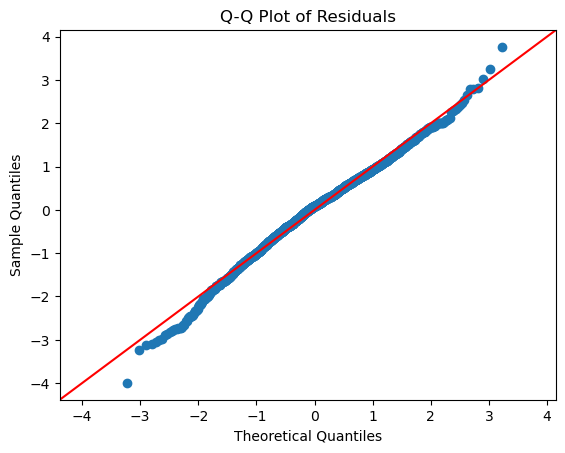

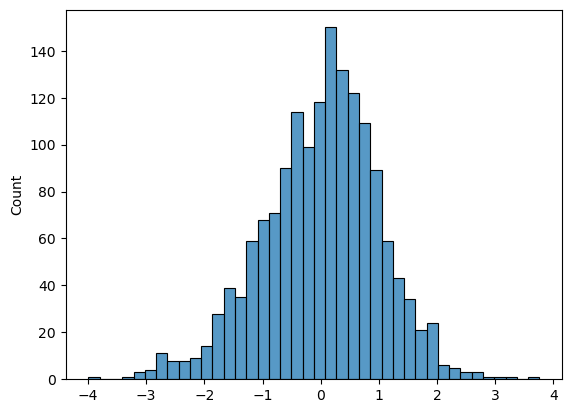

In [107]:
# Generate Q-Q plot
sm.qqplot(standard_resid, line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.show()

sns.histplot(standard_resid, bins=40)
plt.show()

#### Linearity and Identical

Assumption satisifed

Text(0.5, 1.0, 'Fitted values vs Standardized residuals')

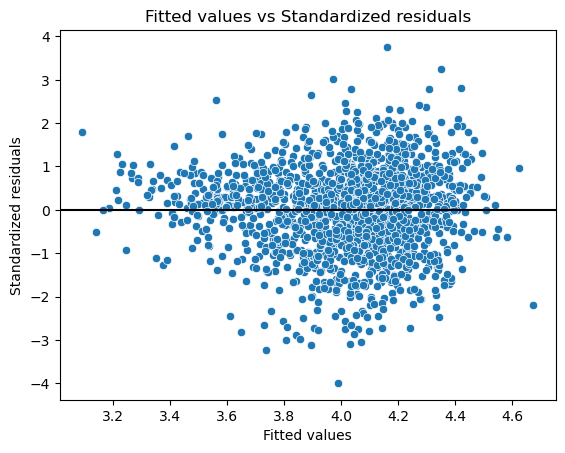

In [110]:
fig, ax = plt.subplots()
sns.scatterplot(x=final_model.fittedvalues, y=standard_resid, ax=ax).axhline(0, color="black")
ax.set_xlabel("Fitted values")
ax.set_ylabel("Standardized residuals")
plt.title("Fitted values vs Standardized residuals")

#### Independence

Assumption satisfied

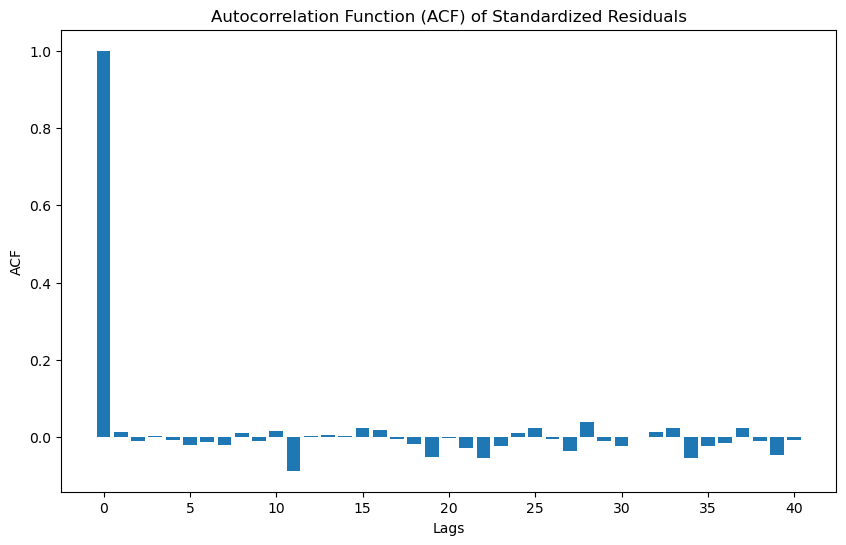

In [113]:
# Compute the ACF of the residuals
acf_values = acf(standard_resid, nlags=40)

# Plot the ACF of the residuals
plt.figure(figsize=(10, 6))
plt.bar(range(len(acf_values)), acf_values)
plt.title('Autocorrelation Function (ACF) of Standardized Residuals')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()

## Conclusion